Anggota Kelompok:
1. Affan Ardana 20.11.3636
2. Darussalaam Nur Rasyidu 20.11.3637

# Analisis Performa Algoritma Gradient Boost untuk Menentukan Feature dan Parameter yang Paling Optimal dalam Memprediksi Pergerakan Harga Saham

## Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import xgboost as xgb
from sklearn.metrics import mean_squared_error

## Menyiapkan Data

#### Load dataset

In [42]:
amazon = pd.read_csv('./AMZN.csv')

In [43]:
amazon.head()

Date       Low      Open      Volume      High     Close  \
0  15-05-1997  0.096354  0.121875  1443120000  0.125000  0.097917   
1  16-05-1997  0.085417  0.098438   294000000  0.098958  0.086458   
2  19-05-1997  0.081250  0.088021   122136000  0.088542  0.085417   
3  20-05-1997  0.081771  0.086458   109344000  0.087500  0.081771   
4  21-05-1997  0.068750  0.081771   377064000  0.082292  0.071354   

   Adjusted Close  
0        0.097917  
1        0.086458  
2        0.085417  
3        0.081771  
4        0.071354

In [44]:
amazon.tail()

Date         Low        Open    Volume        High       Close  \
6399  18-10-2022  114.790001  119.059998  65607400  119.519997  116.360001   
6400  19-10-2022  113.220001  114.709999  47198100  116.589996  115.070000   
6401  20-10-2022  113.510002  113.830002  48795100  118.239998  115.250000   
6402  21-10-2022  114.500000  114.790001  55611900  119.589996  119.320000   
6403  24-10-2022  116.574997  119.980003  23475015  120.389999  119.089996   

      Adjusted Close  
6399      116.360001  
6400      115.070000  
6401      115.250000  
6402      119.320000  
6403      119.089996

In [45]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6404 entries, 0 to 6403
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Date            6404 non-null   object 
 1   Low             6404 non-null   float64
 2   Open            6404 non-null   float64
 3   Volume          6404 non-null   int64  
 4   High            6404 non-null   float64
 5   Close           6404 non-null   float64
 6   Adjusted Close  6404 non-null   float64
dtypes: float64(5), int64(1), object(1)
memory usage: 350.3+ KB


#### Merubah tipe data kolom `Date` menjadi `datetime` dengan format YYYY/MM/DD

In [46]:
amazon['Date'] = pd.to_datetime(amazon['Date'], format='%d-%m-%Y')

In [47]:
amazon.head()

Date       Low      Open      Volume      High     Close  \
0 1997-05-15  0.096354  0.121875  1443120000  0.125000  0.097917   
1 1997-05-16  0.085417  0.098438   294000000  0.098958  0.086458   
2 1997-05-19  0.081250  0.088021   122136000  0.088542  0.085417   
3 1997-05-20  0.081771  0.086458   109344000  0.087500  0.081771   
4 1997-05-21  0.068750  0.081771   377064000  0.082292  0.071354   

   Adjusted Close  
0        0.097917  
1        0.086458  
2        0.085417  
3        0.081771  
4        0.071354

In [48]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6404 entries, 0 to 6403
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            6404 non-null   datetime64[ns]
 1   Low             6404 non-null   float64       
 2   Open            6404 non-null   float64       
 3   Volume          6404 non-null   int64         
 4   High            6404 non-null   float64       
 5   Close           6404 non-null   float64       
 6   Adjusted Close  6404 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 350.3 KB


#### Membuat kolom `Close Before` yang berisi harga close pada hari sebelumnya

In [49]:
amazon['Close Before'] = amazon['Close'].shift(1)

In [50]:
amazon.head()

Date       Low      Open      Volume      High     Close  \
0 1997-05-15  0.096354  0.121875  1443120000  0.125000  0.097917   
1 1997-05-16  0.085417  0.098438   294000000  0.098958  0.086458   
2 1997-05-19  0.081250  0.088021   122136000  0.088542  0.085417   
3 1997-05-20  0.081771  0.086458   109344000  0.087500  0.081771   
4 1997-05-21  0.068750  0.081771   377064000  0.082292  0.071354   

   Adjusted Close  Close Before  
0        0.097917           NaN  
1        0.086458      0.097917  
2        0.085417      0.086458  
3        0.081771      0.085417  
4        0.071354      0.081771

In [51]:
amazon = amazon.reindex(columns=[
    'Date', 'Low', 'Open', 'Volume', 'High',
    'Close', 'Close Before', 'Adjusted Close'
])

amazon.head()

Date       Low      Open      Volume      High     Close  \
0 1997-05-15  0.096354  0.121875  1443120000  0.125000  0.097917   
1 1997-05-16  0.085417  0.098438   294000000  0.098958  0.086458   
2 1997-05-19  0.081250  0.088021   122136000  0.088542  0.085417   
3 1997-05-20  0.081771  0.086458   109344000  0.087500  0.081771   
4 1997-05-21  0.068750  0.081771   377064000  0.082292  0.071354   

   Close Before  Adjusted Close  
0           NaN        0.097917  
1      0.097917        0.086458  
2      0.086458        0.085417  
3      0.085417        0.081771  
4      0.081771        0.071354

In [52]:
amazon = amazon.drop(amazon.index[0]).reset_index(drop=True)

amazon.head()

Date       Low      Open     Volume      High     Close  Close Before  \
0 1997-05-16  0.085417  0.098438  294000000  0.098958  0.086458      0.097917   
1 1997-05-19  0.081250  0.088021  122136000  0.088542  0.085417      0.086458   
2 1997-05-20  0.081771  0.086458  109344000  0.087500  0.081771      0.085417   
3 1997-05-21  0.068750  0.081771  377064000  0.082292  0.071354      0.081771   
4 1997-05-22  0.065625  0.071875  235536000  0.072396  0.069792      0.071354   

   Adjusted Close  
0        0.086458  
1        0.085417  
2        0.081771  
3        0.071354  
4        0.069792

Hapus kolom `Close`

In [53]:
amazon = amazon.drop('Close', axis=1)

In [54]:
amazon.head()

Date       Low      Open     Volume      High  Close Before  \
0 1997-05-16  0.085417  0.098438  294000000  0.098958      0.097917   
1 1997-05-19  0.081250  0.088021  122136000  0.088542      0.086458   
2 1997-05-20  0.081771  0.086458  109344000  0.087500      0.085417   
3 1997-05-21  0.068750  0.081771  377064000  0.082292      0.081771   
4 1997-05-22  0.065625  0.071875  235536000  0.072396      0.071354   

   Adjusted Close  
0        0.086458  
1        0.085417  
2        0.081771  
3        0.071354  
4        0.069792

In [55]:
amazon.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6403 entries, 0 to 6402
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   Date            6403 non-null   datetime64[ns]
 1   Low             6403 non-null   float64       
 2   Open            6403 non-null   float64       
 3   Volume          6403 non-null   int64         
 4   High            6403 non-null   float64       
 5   Close Before    6403 non-null   float64       
 6   Adjusted Close  6403 non-null   float64       
dtypes: datetime64[ns](1), float64(5), int64(1)
memory usage: 350.3 KB


## Exploratory Data Analysis (EDA)

#### Melihat tanggal pertama dan terakhir dari dataset

In [56]:
print(f"Tanggal data pertama: {amazon['Date'].min()}")
print(f"Tanggal data terakhir: {amazon['Date'].max()}")

Tanggal data pertama: 1997-05-16 00:00:00
Tanggal data terakhir: 2022-10-24 00:00:00


#### Plot semua kolom terhadap `Date`

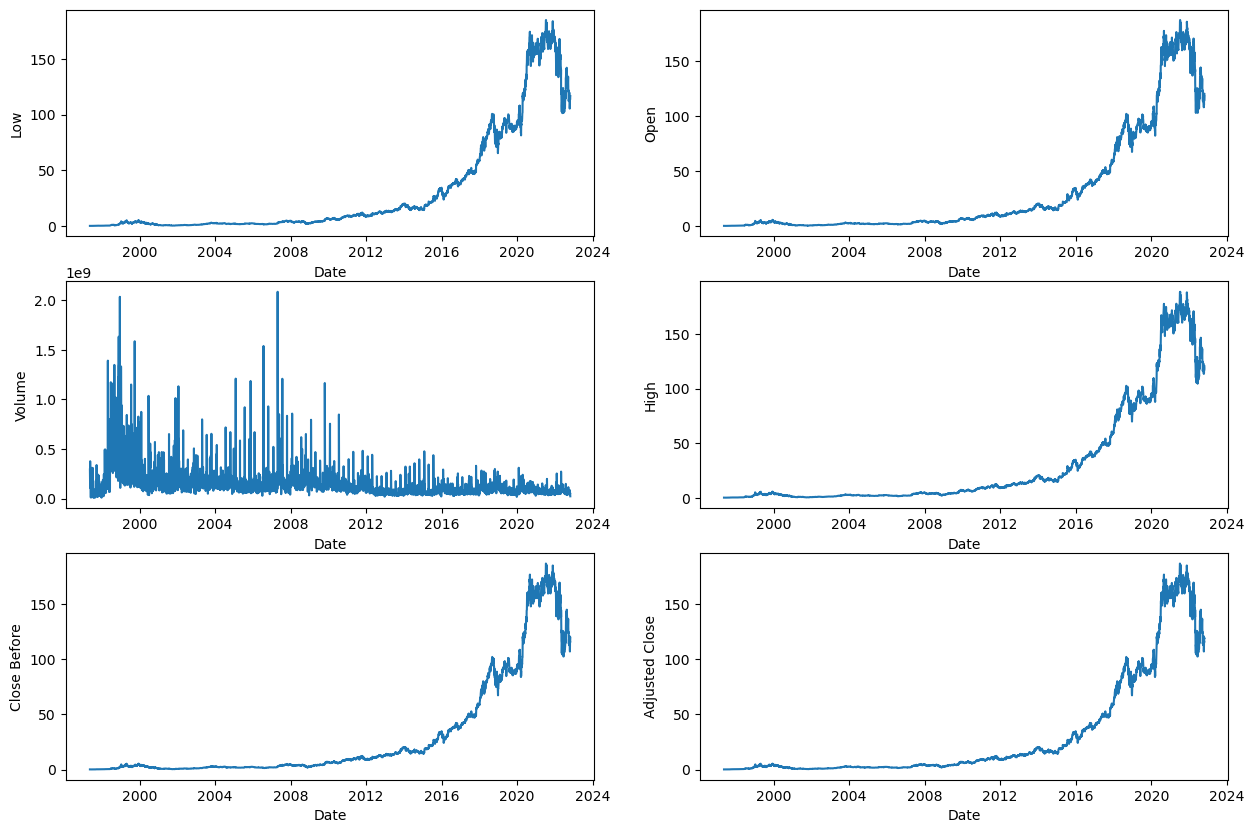

In [57]:
cols = ["Low", "Open", "Volume", "High", "Close Before", "Adjusted Close"]

fig, axs  = plt.subplots(3, 2, figsize=(15, 10))

for col, ax in zip(cols, axs.flat):
        ax.plot(amazon["Date"], amazon[col])

        ax.set_xlabel("Date")
        ax.set_ylabel(col)

plt.show()

#### Sebaran data setiap kolom

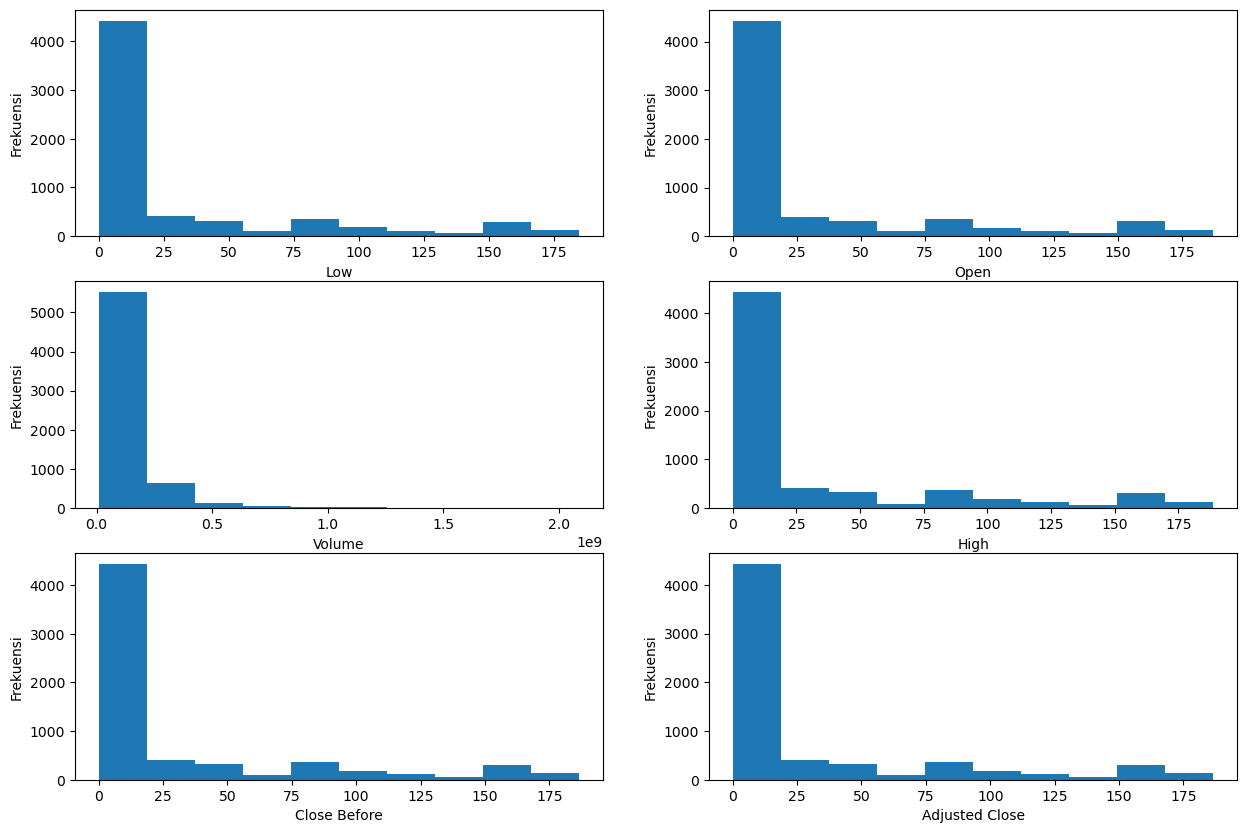

In [58]:
cols = ["Low", "Open", "Volume", "High", "Close Before", "Adjusted Close"]

fig, axs  = plt.subplots(3, 2, figsize=(15, 10))

for col, ax in zip(cols, axs.flat):
        ax.hist(amazon[col], bins=10)

        ax.set_xlabel(col)
        ax.set_ylabel('Frekuensi')

plt.show()

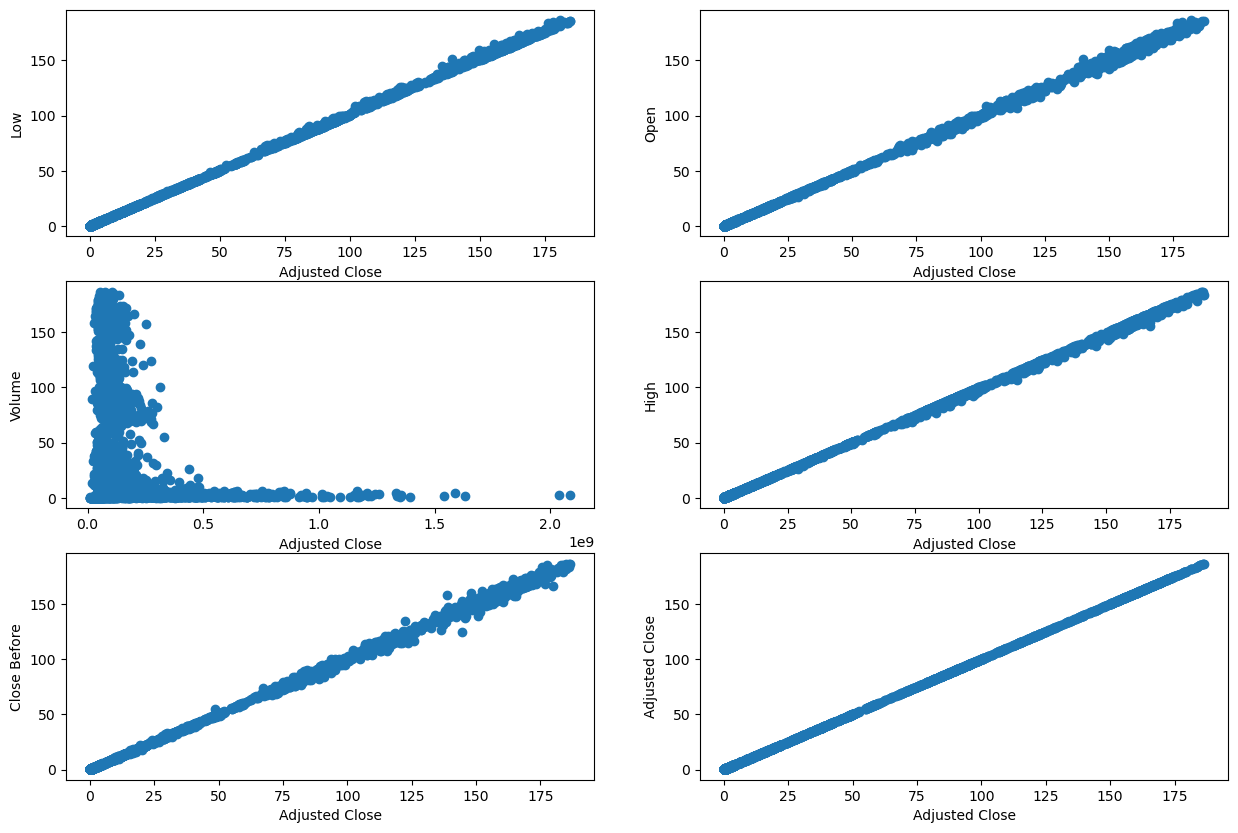

In [149]:
cols = ["Low", "Open", "Volume", "High", "Close Before", "Adjusted Close"]

fig, axs  = plt.subplots(3, 2, figsize=(15, 10))

for col, ax in zip(cols, axs.flat):
        ax.scatter(amazon[col], amazon['Adjusted Close'])

        ax.set_xlabel('Adjusted Close')
        ax.set_ylabel(col)
        
plt.show()

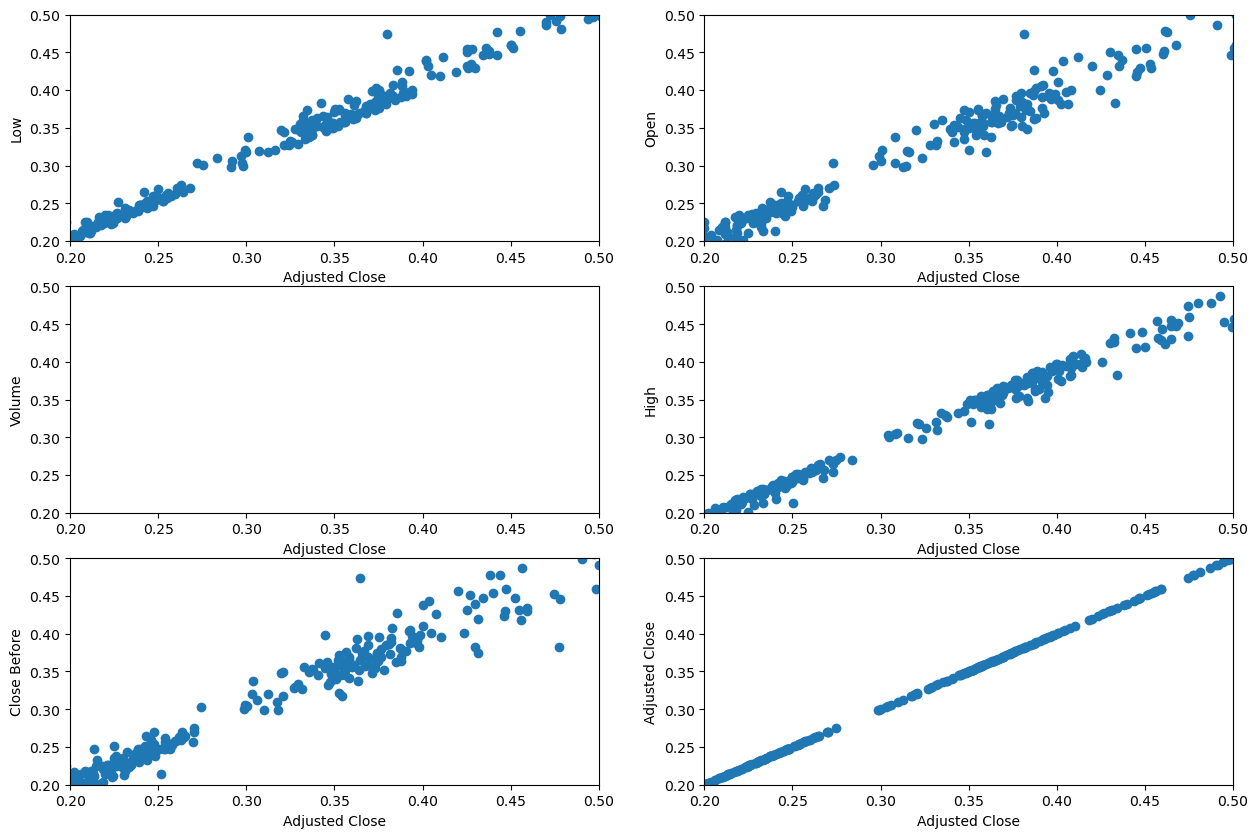

In [151]:
cols = ["Low", "Open", "Volume", "High", "Close Before", "Adjusted Close"]

fig, axs  = plt.subplots(3, 2, figsize=(15, 10))

for col, ax in zip(cols, axs.flat):
        ax.scatter(amazon[col], amazon['Adjusted Close'])

        ax.set_xlabel('Adjusted Close')
        ax.set_ylabel(col)
        ax.set_xlim(0.2, 0.5)
        ax.set_ylim(0.2, 0.5)
 
plt.show()

In [59]:
amazon.describe()

Low         Open        Volume         High  Close Before  \
count  6403.000000  6403.000000  6.403000e+03  6403.000000   6403.000000   
mean     30.106593    30.501912  1.434879e+08    30.862721     30.472254   
std      47.142657    47.757823  1.401249e+08    48.308967     47.711314   
min       0.065625     0.070313  9.744000e+06     0.072396      0.069792   
25%       1.943000     1.977250  6.944800e+07     2.014000      1.983250   
50%       6.038000     6.153000  1.066980e+08     6.284000      6.160500   
75%      35.625999    35.863001  1.620370e+08    36.114250     35.885500   
max     184.839493   187.199997  2.086584e+09   188.654007    186.570496   

       Adjusted Close  
count     6403.000000  
mean        30.490838  
std         47.722654  
min          0.069792  
25%          1.984250  
50%          6.162000  
75%         35.896000  
max        186.570496

In [60]:
print(f"Low: nilai min = {amazon['Low'].min()}, nilai max = {amazon['Low'].max()}")
print(f"Open: nilai min = {amazon['Open'].min()}, nilai max = {amazon['Open'].max()}")
print(f"Volume: nilai min = {amazon['Volume'].min()}, nilai max = {amazon['Volume'].max()}")
print(f"High: nilai min = {amazon['High'].min()}, nilai max = {amazon['High'].max()}")
print(f"Close Before: nilai min = {amazon['Close Before'].min()}, nilai max = {amazon['Close Before'].max()}")
print(f"Adjusted Close: nilai min = {amazon['Adjusted Close'].min()}, nilai max = {amazon['Adjusted Close'].max()}")

Low: nilai min = 0.0656249970197677, nilai max = 184.8394927978516
Open: nilai min = 0.0703129991889, nilai max = 187.1999969482422
Volume: nilai min = 9744000, nilai max = 2086584000
High: nilai min = 0.0723960027098655, nilai max = 188.6540069580078
Close Before: nilai min = 0.0697920024394989, nilai max = 186.57049560546875
Adjusted Close: nilai min = 0.0697920024394989, nilai max = 186.57049560546875


## Pre-processing

### Features selection

Menggunakan Pearson Correlation

In [61]:
correlation = amazon.corr()

#### Nilai Pearson Correlation

In [62]:
print(correlation)

                     Low      Open    Volume      High  Close Before  \
Low             1.000000  0.999899 -0.259902  0.999873      0.999778   
Open            0.999899  1.000000 -0.258661  0.999918      0.999878   
Volume         -0.259902 -0.258661  1.000000 -0.257512     -0.258708   
High            0.999873  0.999918 -0.257512  1.000000      0.999810   
Close Before    0.999778  0.999878 -0.258708  0.999810      1.000000   
Adjusted Close  0.999908  0.999800 -0.258702  0.999904      0.999680   

                Adjusted Close  
Low                   0.999908  
Open                  0.999800  
Volume               -0.258702  
High                  0.999904  
Close Before          0.999680  
Adjusted Close        1.000000  


#### Heatmap Pearson Correlation

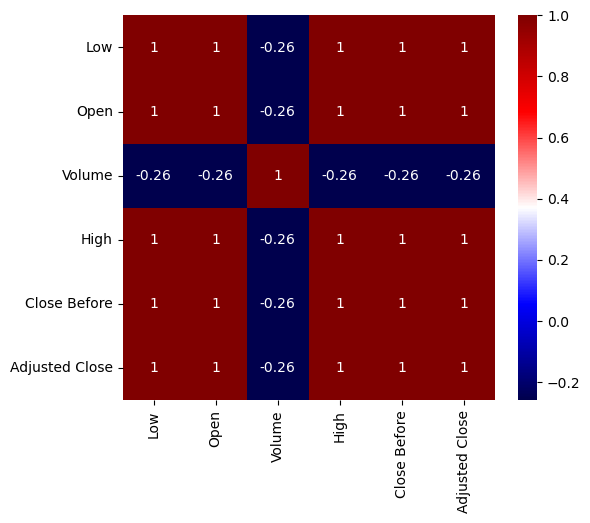

In [63]:
plt.figure(figsize=(6, 5))
sns.heatmap(correlation, cmap='seismic', annot=True)

plt.show()

#### Features yang terpilih

Feature yang terpilih memiliki korelasi lebih dari 0.6 terhadap `Adjusted Close`

In [64]:
corr_target = abs(correlation['Adjusted Close'])

relevant_features = corr_target[corr_target > 0.6]
print(relevant_features)

Low               0.999908
Open              0.999800
High              0.999904
Close Before      0.999680
Adjusted Close    1.000000
Name: Adjusted Close, dtype: float64


#### Dataframe baru yang berisi features yang relevan

In [65]:
relevant = amazon.copy()
relevant.drop(labels='Volume', axis=1, inplace=True)

relevant.head()

Date       Low      Open      High  Close Before  Adjusted Close
0 1997-05-16  0.085417  0.098438  0.098958      0.097917        0.086458
1 1997-05-19  0.081250  0.088021  0.088542      0.086458        0.085417
2 1997-05-20  0.081771  0.086458  0.087500      0.085417        0.081771
3 1997-05-21  0.068750  0.081771  0.082292      0.081771        0.071354
4 1997-05-22  0.065625  0.071875  0.072396      0.071354        0.069792

### Scaling

melakukan scaling data dengan rentang 0-1

In [66]:
scaler = MinMaxScaler(feature_range=(0, 1))

scaled = scaler.fit_transform(relevant.iloc[:, 1:])

#### Dataframe yang nilainya sudah di-scaling

In [67]:
scaled = pd.DataFrame(scaled, columns=['Low', 'Open', 'High', 'Close Before', 'Adjusted Close'])
scaled.insert(0, 'Date', amazon['Date'], True)
scaled.head()

Date       Low      Open      High  Close Before  Adjusted Close
0 1997-05-16  0.000107  0.000150  0.000141      0.000151        0.000089
1 1997-05-19  0.000085  0.000095  0.000086      0.000089        0.000084
2 1997-05-20  0.000087  0.000086  0.000080      0.000084        0.000064
3 1997-05-21  0.000017  0.000061  0.000052      0.000064        0.000008
4 1997-05-22  0.000000  0.000008  0.000000      0.000008        0.000000

## Cross Validation

Menggunakan Time Series Split

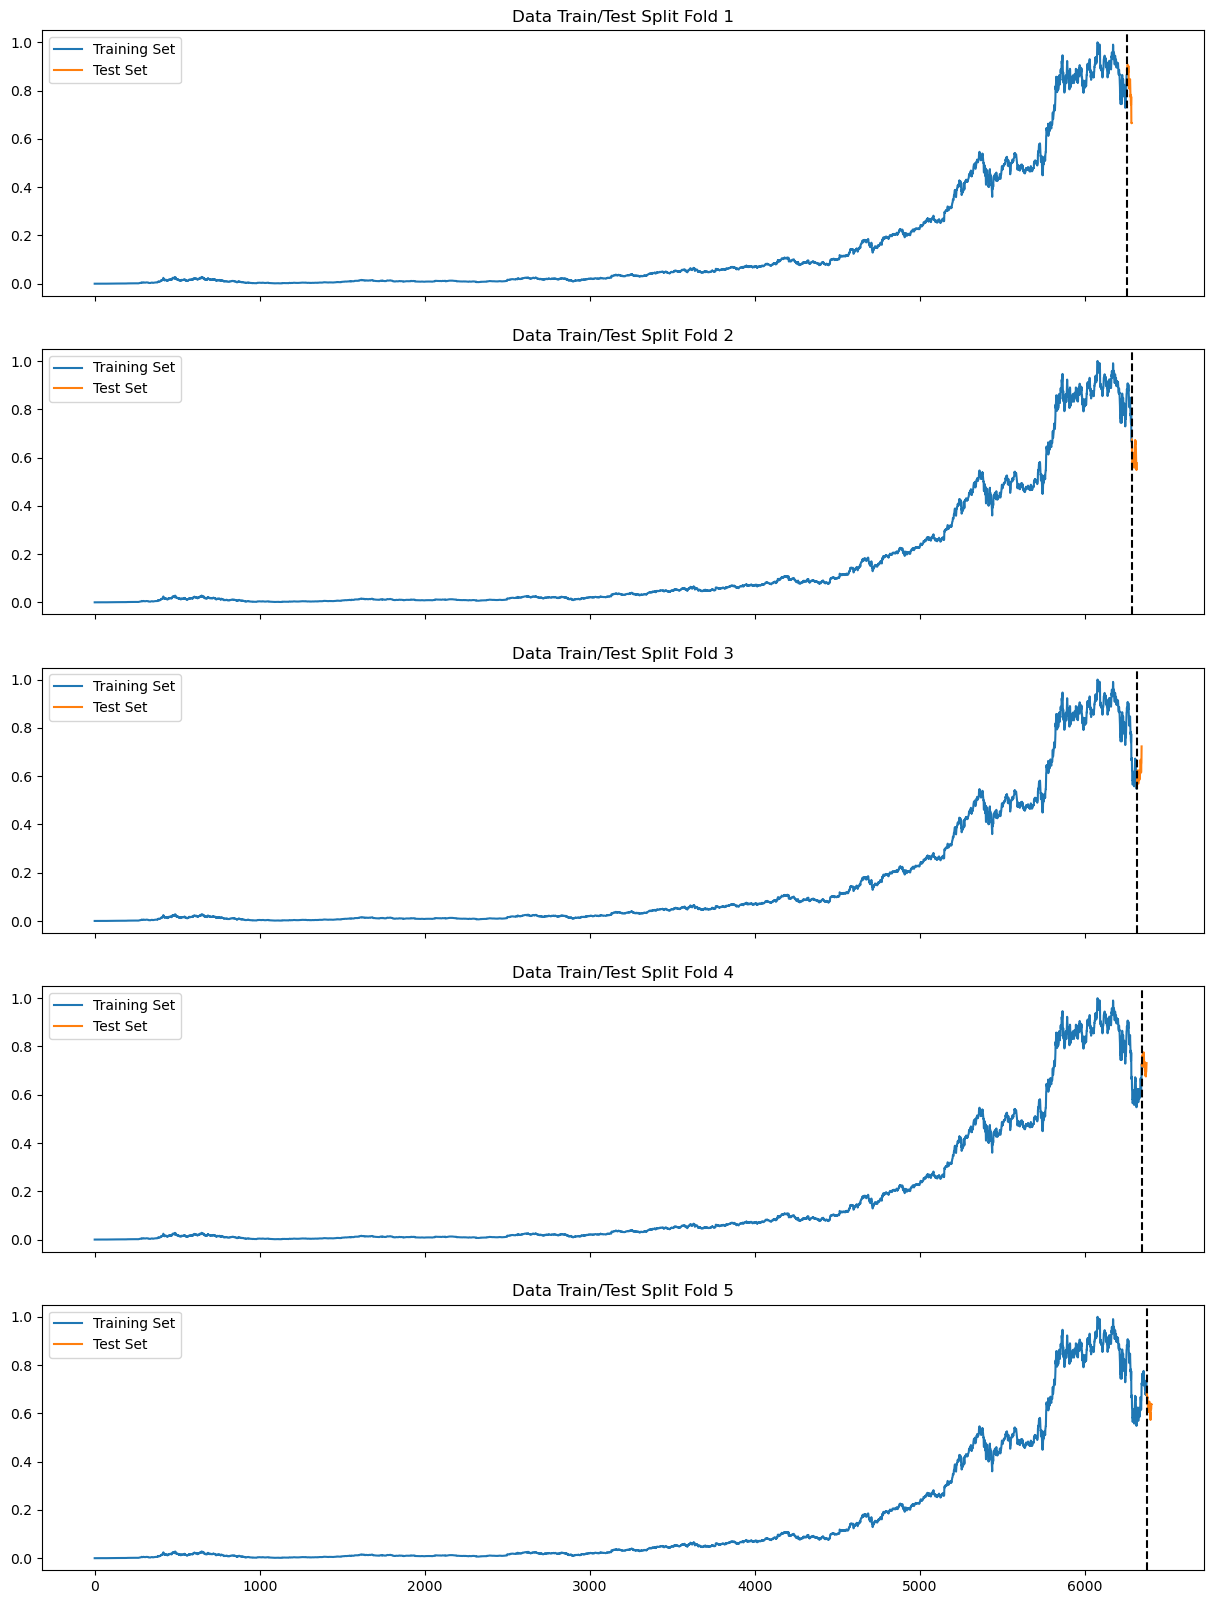

In [68]:
tss = TimeSeriesSplit(n_splits=5, test_size=30)

fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(scaled):
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    train['Adjusted Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}')
    test['Adjusted Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1

plt.show()


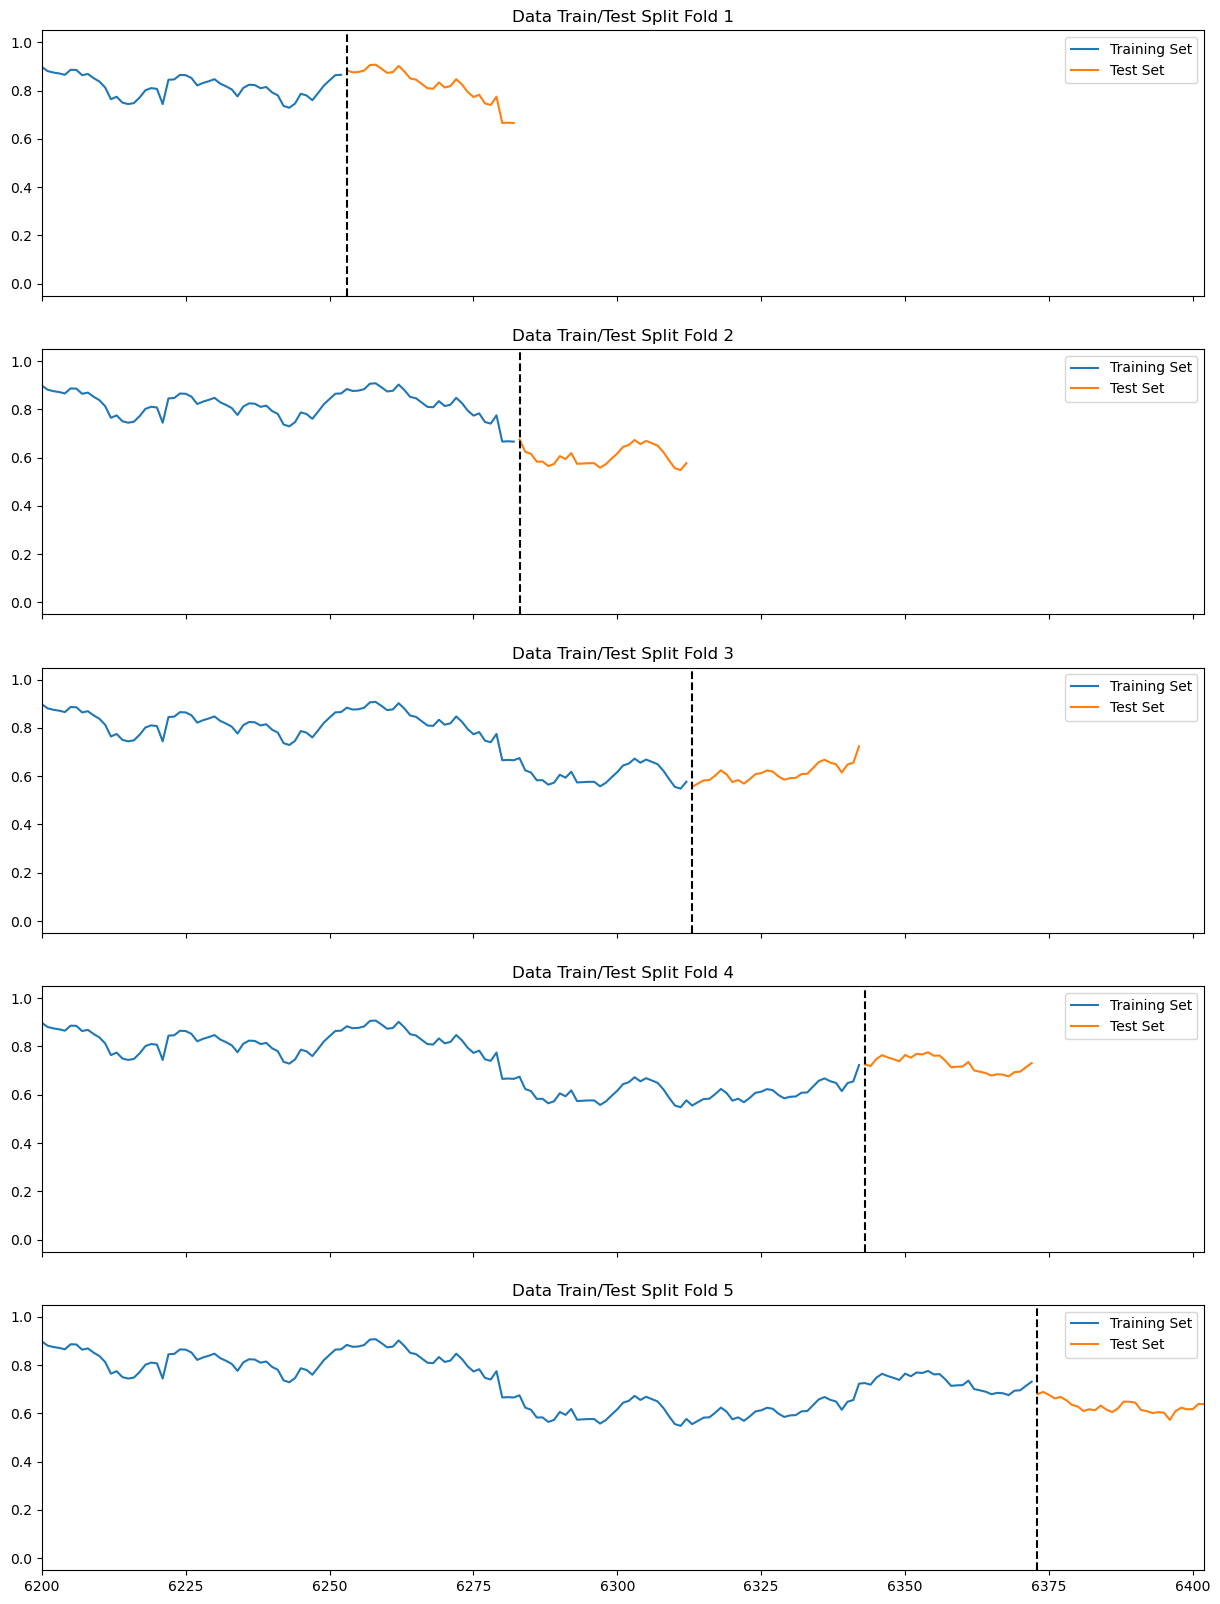

In [70]:
fig, axs = plt.subplots(5, 1, figsize=(15, 20), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(scaled):
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    train['Adjusted Close'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold+1}')
    test['Adjusted Close'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    axs[fold].legend()
    fold += 1

plt.xlim(scaled.index[6200], scaled.index[6402])
plt.show()

## Model

Jumlah pohon = 500

Early stopping rounds = 3

Learning rate = 0.01, 0.05, 0.1

kedalaman pohon = 3, 4, 5

Model = 1 x 3 x 3 = 9

### Model 1
### Learning rate=0.01, kedalaman pohon=3

In [72]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 3}

pred_lr001_kp3 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr001_kp3 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr001_kp3.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr001_kp3['date_fold_' + str(fold)] = test_date.values
    pred_lr001_kp3['real_fold_' + str(fold)] = y_test.values
    pred_lr001_kp3['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.42267	validation_1-rmse:0.32558
[50]	validation_0-rmse:0.25624	validation_1-rmse:0.19430
[100]	validation_0-rmse:0.15540	validation_1-rmse:0.11697
[150]	validation_0-rmse:0.09430	validation_1-rmse:0.07093
[200]	validation_0-rmse:0.05727	validation_1-rmse:0.04355
[250]	validation_0-rmse:0.03483	validation_1-rmse:0.02766
[300]	validation_0-rmse:0.02124	validation_1-rmse:0.01905
[350]	validation_0-rmse:0.01304	validation_1-rmse:0.01469
[400]	validation_0-rmse:0.00812	validation_1-rmse:0.01256
[450]	validation_0-rmse:0.00522	validation_1-rmse:0.01162
[499]	validation_0-rmse:0.00362	validation_1-rmse:0.01127


Train pada Fold-2
[0]	validation_0-rmse:0.42226	validation_1-rmse:0.11193
[50]	validation_0-rmse:0.25600	validation_1-rmse:0.07447
[100]	validation_0-rmse:0.15526	validation_1-rmse:0.04734
[150]	validation_0-rmse:0.09422	validation_1-rmse:0.03068
[200]	validation_0-rmse:0.05723	validation_1-rmse:0.02084
[250]	validation_0-rmse:0.03481	validati

In [73]:
pred_lr001_kp3 = pred_lr001_kp3.reset_index(drop=True)
pred_lr001_kp3.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.875823  2022-05-04     0.674843     0.658907   
1  2022-03-23     0.875805     0.875823  2022-05-05     0.623790     0.631496   
2  2022-03-24     0.877100     0.866776  2022-05-06     0.615026     0.615864   
3  2022-03-25     0.883126     0.875823  2022-05-09     0.582943     0.579657   
4  2022-03-28     0.905738     0.892289  2022-05-10     0.583318     0.576856   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.547838  2022-08-01     0.725575     0.725689   
1  2022-06-17     0.569168     0.565434  2022-08-02     0.718980     0.727941   
2  2022-06-21     0.582358     0.573353  2022-08-03     0.747719     0.738546   
3  2022-06-22     0.583806     0.576281  2022-08-04     0.764073     0.766275   
4  2022-06-23     0.602519     0.585985  2022-08-05     0.754583     0.766275   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.686793  
1  2022-09-14     0.688899     0.686793  
2  2022-09-15     0.676728     0.686793  
3  2022-09-16     0.661983     0.657631  
4  2022-09-19     0.668042     0.660256

### Model 2
### Learning rate=0.01, kedalaman pohon=4

In [74]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 4}

pred_lr001_kp4 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr001_kp4 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr001_kp4.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr001_kp4['date_fold_' + str(fold)] = test_date.values
    pred_lr001_kp4['real_fold_' + str(fold)] = y_test.values
    pred_lr001_kp4['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.42267	validation_1-rmse:0.32558
[50]	validation_0-rmse:0.25601	validation_1-rmse:0.19715
[100]	validation_0-rmse:0.15509	validation_1-rmse:0.11964
[150]	validation_0-rmse:0.09397	validation_1-rmse:0.07302
[200]	validation_0-rmse:0.05695	validation_1-rmse:0.04522
[250]	validation_0-rmse:0.03455	validation_1-rmse:0.02883
[300]	validation_0-rmse:0.02100	validation_1-rmse:0.01952
[350]	validation_0-rmse:0.01284	validation_1-rmse:0.01471
[400]	validation_0-rmse:0.00796	validation_1-rmse:0.01245
[450]	validation_0-rmse:0.00509	validation_1-rmse:0.01151
[499]	validation_0-rmse:0.00350	validation_1-rmse:0.01115


Train pada Fold-2
[0]	validation_0-rmse:0.42226	validation_1-rmse:0.11115
[50]	validation_0-rmse:0.25577	validation_1-rmse:0.06844
[100]	validation_0-rmse:0.15494	validation_1-rmse:0.04176
[150]	validation_0-rmse:0.09388	validation_1-rmse:0.02674
[200]	validation_0-rmse:0.05690	validation_1-rmse:0.01793
[250]	validation_0-rmse:0.03452	validati

In [75]:
pred_lr001_kp4 = pred_lr001_kp4.reset_index(drop=True)
pred_lr001_kp4.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.875487  2022-05-04     0.674843     0.659285   
1  2022-03-23     0.875805     0.875487  2022-05-05     0.623790     0.632196   
2  2022-03-24     0.877100     0.866008  2022-05-06     0.615026     0.617154   
3  2022-03-25     0.883126     0.875487  2022-05-09     0.582943     0.579503   
4  2022-03-28     0.905738     0.892298  2022-05-10     0.583318     0.576967   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548238  2022-08-01     0.725575     0.723823   
1  2022-06-17     0.569168     0.565985  2022-08-02     0.718980     0.727873   
2  2022-06-21     0.582358     0.573748  2022-08-03     0.747719     0.739351   
3  2022-06-22     0.583806     0.576214  2022-08-04     0.764073     0.764354   
4  2022-06-23     0.602519     0.587137  2022-08-05     0.754583     0.764354   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.685597  
1  2022-09-14     0.688899     0.685597  
2  2022-09-15     0.676728     0.685597  
3  2022-09-16     0.661983     0.657271  
4  2022-09-19     0.668042     0.659489

### Model 3
### Learning rate=0.01, kedalaman pohon=5

In [76]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.01, 'max_depth': 5}

pred_lr001_kp5 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr001_kp5 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr001_kp5.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr001_kp5['date_fold_' + str(fold)] = test_date.values
    pred_lr001_kp5['real_fold_' + str(fold)] = y_test.values
    pred_lr001_kp5['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.42267	validation_1-rmse:0.32558
[50]	validation_0-rmse:0.25599	validation_1-rmse:0.19717
[100]	validation_0-rmse:0.15507	validation_1-rmse:0.11971
[150]	validation_0-rmse:0.09395	validation_1-rmse:0.07292
[200]	validation_0-rmse:0.05694	validation_1-rmse:0.04494
[250]	validation_0-rmse:0.03454	validation_1-rmse:0.02862
[300]	validation_0-rmse:0.02099	validation_1-rmse:0.01947
[350]	validation_0-rmse:0.01282	validation_1-rmse:0.01464
[400]	validation_0-rmse:0.00793	validation_1-rmse:0.01230
[450]	validation_0-rmse:0.00503	validation_1-rmse:0.01133
[499]	validation_0-rmse:0.00339	validation_1-rmse:0.01093


Train pada Fold-2
[0]	validation_0-rmse:0.42226	validation_1-rmse:0.11126
[50]	validation_0-rmse:0.25575	validation_1-rmse:0.06883
[100]	validation_0-rmse:0.15492	validation_1-rmse:0.04277
[150]	validation_0-rmse:0.09386	validation_1-rmse:0.02691
[200]	validation_0-rmse:0.05689	validation_1-rmse:0.01783
[250]	validation_0-rmse:0.03451	validati

In [77]:
pred_lr001_kp5 = pred_lr001_kp5.reset_index(drop=True)
pred_lr001_kp5.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.875813  2022-05-04     0.674843     0.658216   
1  2022-03-23     0.875805     0.875554  2022-05-05     0.623790     0.632967   
2  2022-03-24     0.877100     0.865815  2022-05-06     0.615026     0.617508   
3  2022-03-25     0.883126     0.875554  2022-05-09     0.582943     0.579698   
4  2022-03-28     0.905738     0.892603  2022-05-10     0.583318     0.576939   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.547773  2022-08-01     0.725575     0.724990   
1  2022-06-17     0.569168     0.566575  2022-08-02     0.718980     0.727832   
2  2022-06-21     0.582358     0.573929  2022-08-03     0.747719     0.738359   
3  2022-06-22     0.583806     0.577242  2022-08-04     0.764073     0.765228   
4  2022-06-23     0.602519     0.586808  2022-08-05     0.754583     0.765228   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.685655  
1  2022-09-14     0.688899     0.685752  
2  2022-09-15     0.676728     0.685752  
3  2022-09-16     0.661983     0.656391  
4  2022-09-19     0.668042     0.659349

### Model 4
### Learning rate=0.05, kedalaman pohon=3

In [79]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.05, 'max_depth': 3}

pred_lr005_kp3 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr005_kp3 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr005_kp3.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr005_kp3['date_fold_' + str(fold)] = test_date.values
    pred_lr005_kp3['real_fold_' + str(fold)] = y_test.values
    pred_lr005_kp3['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.40565	validation_1-rmse:0.31211
[50]	validation_0-rmse:0.03178	validation_1-rmse:0.02488
[100]	validation_0-rmse:0.00334	validation_1-rmse:0.01072
[133]	validation_0-rmse:0.00217	validation_1-rmse:0.01053


Train pada Fold-2
[0]	validation_0-rmse:0.40526	validation_1-rmse:0.11032
[50]	validation_0-rmse:0.03176	validation_1-rmse:0.01461
[86]	validation_0-rmse:0.00560	validation_1-rmse:0.01073


Train pada Fold-3
[0]	validation_0-rmse:0.40437	validation_1-rmse:0.11317
[50]	validation_0-rmse:0.03171	validation_1-rmse:0.01677
[100]	validation_0-rmse:0.00342	validation_1-rmse:0.01064
[134]	validation_0-rmse:0.00229	validation_1-rmse:0.01032


Train pada Fold-4
[0]	validation_0-rmse:0.40348	validation_1-rmse:0.21447
[50]	validation_0-rmse:0.03166	validation_1-rmse:0.01325
[89]	validation_0-rmse:0.00498	validation_1-rmse:0.00777


Train pada Fold-5
[0]	validation_0-rmse:0.40281	validation_1-rmse:0.12650
[50]	validation_0-rmse:0.03162	validation_1-rmse

In [80]:
pred_lr005_kp3 = pred_lr005_kp3.reset_index(drop=True)
pred_lr005_kp3.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.877968  2022-05-04     0.674843     0.660981   
1  2022-03-23     0.875805     0.877968  2022-05-05     0.623790     0.635832   
2  2022-03-24     0.877100     0.867798  2022-05-06     0.615026     0.622302   
3  2022-03-25     0.883126     0.877968  2022-05-09     0.582943     0.578625   
4  2022-03-28     0.905738     0.894324  2022-05-10     0.583318     0.575500   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548527  2022-08-01     0.725575     0.728261   
1  2022-06-17     0.569168     0.567026  2022-08-02     0.718980     0.728261   
2  2022-06-21     0.582358     0.574620  2022-08-03     0.747719     0.740335   
3  2022-06-22     0.583806     0.577428  2022-08-04     0.764073     0.763004   
4  2022-06-23     0.602519     0.586512  2022-08-05     0.754583     0.763004   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.685984  
1  2022-09-14     0.688899     0.685984  
2  2022-09-15     0.676728     0.685984  
3  2022-09-16     0.661983     0.660489  
4  2022-09-19     0.668042     0.660625

### Model 5
### Learning rate=0.05, kedalaman pohon=4

In [81]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.05, 'max_depth': 4}

pred_lr005_kp4 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr005_kp4 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr005_kp4.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr005_kp4['date_fold_' + str(fold)] = test_date.values
    pred_lr005_kp4['real_fold_' + str(fold)] = y_test.values
    pred_lr005_kp4['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.40563	validation_1-rmse:0.31213
[50]	validation_0-rmse:0.03150	validation_1-rmse:0.02695
[100]	validation_0-rmse:0.00317	validation_1-rmse:0.01126
[150]	validation_0-rmse:0.00180	validation_1-rmse:0.01081
[189]	validation_0-rmse:0.00163	validation_1-rmse:0.01069


Train pada Fold-2
[0]	validation_0-rmse:0.40523	validation_1-rmse:0.10643
[50]	validation_0-rmse:0.03147	validation_1-rmse:0.01291
[83]	validation_0-rmse:0.00621	validation_1-rmse:0.01040


Train pada Fold-3
[0]	validation_0-rmse:0.40434	validation_1-rmse:0.11296
[50]	validation_0-rmse:0.03141	validation_1-rmse:0.01570
[100]	validation_0-rmse:0.00325	validation_1-rmse:0.01111
[141]	validation_0-rmse:0.00198	validation_1-rmse:0.01086


Train pada Fold-4
[0]	validation_0-rmse:0.40345	validation_1-rmse:0.21835
[50]	validation_0-rmse:0.03135	validation_1-rmse:0.01648
[90]	validation_0-rmse:0.00464	validation_1-rmse:0.00754


Train pada Fold-5
[0]	validation_0-rmse:0.40278	validation_1-rms

In [82]:
pred_lr005_kp4 = pred_lr005_kp4.reset_index(drop=True)
pred_lr005_kp4.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.879039  2022-05-04     0.674843     0.659179   
1  2022-03-23     0.875805     0.878382  2022-05-05     0.623790     0.631779   
2  2022-03-24     0.877100     0.865100  2022-05-06     0.615026     0.617963   
3  2022-03-25     0.883126     0.877891  2022-05-09     0.582943     0.579293   
4  2022-03-28     0.905738     0.895080  2022-05-10     0.583318     0.576748   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548910  2022-08-01     0.725575     0.724575   
1  2022-06-17     0.569168     0.565132  2022-08-02     0.718980     0.727899   
2  2022-06-21     0.582358     0.574570  2022-08-03     0.747719     0.739627   
3  2022-06-22     0.583806     0.576893  2022-08-04     0.764073     0.762555   
4  2022-06-23     0.602519     0.587558  2022-08-05     0.754583     0.762555   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.685609  
1  2022-09-14     0.688899     0.685609  
2  2022-09-15     0.676728     0.685609  
3  2022-09-16     0.661983     0.658029  
4  2022-09-19     0.668042     0.660083

### Model 6
### Learning rate=0.05, kedalaman pohon=5

In [83]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.05, 'max_depth': 5}

pred_lr005_kp5 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr005_kp5 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr005_kp5.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr005_kp5['date_fold_' + str(fold)] = test_date.values
    pred_lr005_kp5['real_fold_' + str(fold)] = y_test.values
    pred_lr005_kp5['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.40562	validation_1-rmse:0.31211
[50]	validation_0-rmse:0.03148	validation_1-rmse:0.02662
[100]	validation_0-rmse:0.00306	validation_1-rmse:0.01092
[144]	validation_0-rmse:0.00159	validation_1-rmse:0.01051


Train pada Fold-2
[0]	validation_0-rmse:0.40523	validation_1-rmse:0.10700
[50]	validation_0-rmse:0.03146	validation_1-rmse:0.01263
[78]	validation_0-rmse:0.00778	validation_1-rmse:0.01059


Train pada Fold-3
[0]	validation_0-rmse:0.40433	validation_1-rmse:0.11271
[50]	validation_0-rmse:0.03139	validation_1-rmse:0.01516
[100]	validation_0-rmse:0.00312	validation_1-rmse:0.01083
[122]	validation_0-rmse:0.00196	validation_1-rmse:0.01070


Train pada Fold-4
[0]	validation_0-rmse:0.40345	validation_1-rmse:0.21835
[50]	validation_0-rmse:0.03133	validation_1-rmse:0.01527
[85]	validation_0-rmse:0.00563	validation_1-rmse:0.00776


Train pada Fold-5
[0]	validation_0-rmse:0.40278	validation_1-rmse:0.12603
[50]	validation_0-rmse:0.03128	validation_1-rmse

In [84]:
pred_lr005_kp5 = pred_lr005_kp5.reset_index(drop=True)
pred_lr005_kp5.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.878983  2022-05-04     0.674843     0.657850   
1  2022-03-23     0.875805     0.878585  2022-05-05     0.623790     0.632332   
2  2022-03-24     0.877100     0.865831  2022-05-06     0.615026     0.617549   
3  2022-03-25     0.883126     0.878134  2022-05-09     0.582943     0.579225   
4  2022-03-28     0.905738     0.894365  2022-05-10     0.583318     0.576642   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.547931  2022-08-01     0.725575     0.724488   
1  2022-06-17     0.569168     0.566838  2022-08-02     0.718980     0.727881   
2  2022-06-21     0.582358     0.574201  2022-08-03     0.747719     0.739349   
3  2022-06-22     0.583806     0.577718  2022-08-04     0.764073     0.764131   
4  2022-06-23     0.602519     0.587436  2022-08-05     0.754583     0.764131   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.685840  
1  2022-09-14     0.688899     0.686251  
2  2022-09-15     0.676728     0.686251  
3  2022-09-16     0.661983     0.657332  
4  2022-09-19     0.668042     0.660417

### Model 7
### Learning rate=0.1, kedalaman pohon=3

In [85]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.1, 'max_depth': 3}

pred_lr01_kp3 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr01_kp3 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr01_kp3.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr01_kp3['date_fold_' + str(fold)] = test_date.values
    pred_lr01_kp3['real_fold_' + str(fold)] = y_test.values
    pred_lr01_kp3['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.38438	validation_1-rmse:0.29529
[50]	validation_0-rmse:0.00320	validation_1-rmse:0.01050
[72]	validation_0-rmse:0.00232	validation_1-rmse:0.01035


Train pada Fold-2
[0]	validation_0-rmse:0.38401	validation_1-rmse:0.10831
[50]	validation_0-rmse:0.00325	validation_1-rmse:0.01142
[53]	validation_0-rmse:0.00292	validation_1-rmse:0.01142


Train pada Fold-3
[0]	validation_0-rmse:0.38317	validation_1-rmse:0.10772
[50]	validation_0-rmse:0.00328	validation_1-rmse:0.01120
[62]	validation_0-rmse:0.00256	validation_1-rmse:0.01104


Train pada Fold-4
[0]	validation_0-rmse:0.38233	validation_1-rmse:0.19958
[38]	validation_0-rmse:0.00770	validation_1-rmse:0.00908


Train pada Fold-5
[0]	validation_0-rmse:0.38170	validation_1-rmse:0.12037
[45]	validation_0-rmse:0.00438	validation_1-rmse:0.00972




In [86]:
pred_lr01_kp3 = pred_lr01_kp3.reset_index(drop=True)
pred_lr01_kp3.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.876049  2022-05-04     0.674843     0.663610   
1  2022-03-23     0.875805     0.876049  2022-05-05     0.623790     0.612523   
2  2022-03-24     0.877100     0.870732  2022-05-06     0.615026     0.611518   
3  2022-03-25     0.883126     0.876049  2022-05-09     0.582943     0.581802   
4  2022-03-28     0.905738     0.894576  2022-05-10     0.583318     0.581802   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.546174  2022-08-01     0.725575     0.723881   
1  2022-06-17     0.569168     0.566884  2022-08-02     0.718980     0.723881   
2  2022-06-21     0.582358     0.574075  2022-08-03     0.747719     0.734461   
3  2022-06-22     0.583806     0.577409  2022-08-04     0.764073     0.761592   
4  2022-06-23     0.602519     0.584994  2022-08-05     0.754583     0.761592   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.692081  
1  2022-09-14     0.688899     0.692081  
2  2022-09-15     0.676728     0.692081  
3  2022-09-16     0.661983     0.660912  
4  2022-09-19     0.668042     0.660912

### Model 8
### Learning rate=0.1, kedalaman pohon=4

In [87]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.1, 'max_depth': 4}

pred_lr01_kp4 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr01_kp4 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr01_kp4.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr01_kp4['date_fold_' + str(fold)] = test_date.values
    pred_lr01_kp4['real_fold_' + str(fold)] = y_test.values
    pred_lr01_kp4['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.38433	validation_1-rmse:0.29533
[50]	validation_0-rmse:0.00289	validation_1-rmse:0.01065
[88]	validation_0-rmse:0.00172	validation_1-rmse:0.01028


Train pada Fold-2
[0]	validation_0-rmse:0.38395	validation_1-rmse:0.10058
[42]	validation_0-rmse:0.00517	validation_1-rmse:0.01044


Train pada Fold-3
[0]	validation_0-rmse:0.38311	validation_1-rmse:0.10728
[50]	validation_0-rmse:0.00299	validation_1-rmse:0.01115
[70]	validation_0-rmse:0.00202	validation_1-rmse:0.01069


Train pada Fold-4
[0]	validation_0-rmse:0.38227	validation_1-rmse:0.20732
[43]	validation_0-rmse:0.00479	validation_1-rmse:0.00761


Train pada Fold-5
[0]	validation_0-rmse:0.38163	validation_1-rmse:0.11855
[45]	validation_0-rmse:0.00412	validation_1-rmse:0.00842




In [88]:
pred_lr01_kp4 = pred_lr01_kp4.reset_index(drop=True)
pred_lr01_kp4.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.879135  2022-05-04     0.674843     0.658226   
1  2022-03-23     0.875805     0.879135  2022-05-05     0.623790     0.631058   
2  2022-03-24     0.877100     0.867510  2022-05-06     0.615026     0.617428   
3  2022-03-25     0.883126     0.878007  2022-05-09     0.582943     0.580317   
4  2022-03-28     0.905738     0.895725  2022-05-10     0.583318     0.577937   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.546709  2022-08-01     0.725575     0.723069   
1  2022-06-17     0.569168     0.565775  2022-08-02     0.718980     0.728669   
2  2022-06-21     0.582358     0.574698  2022-08-03     0.747719     0.739190   
3  2022-06-22     0.583806     0.581095  2022-08-04     0.764073     0.764942   
4  2022-06-23     0.602519     0.585464  2022-08-05     0.754583     0.764942   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.686692  
1  2022-09-14     0.688899     0.686692  
2  2022-09-15     0.676728     0.686692  
3  2022-09-16     0.661983     0.656673  
4  2022-09-19     0.668042     0.659415

### Model 9
### Learning rate=0.1, kedalaman pohon=5

In [89]:
params = {'n_estimators': 500, 'early_stopping_rounds': 3, 'learning_rate': 0.1, 'max_depth': 5}

pred_lr01_kp5 = pd.DataFrame(columns=[
    'date_fold_1', 'real_fold_1', 'pred_fold_1',
    'date_fold_2', 'real_fold_2', 'pred_fold_2',
    'date_fold_3', 'real_fold_3', 'pred_fold_3', 
    'date_fold_4', 'real_fold_4', 'pred_fold_4',
    'date_fold_5', 'real_fold_5', 'pred_fold_5'])

models_lr01_kp5 = []

fold = 1
for train_idx, val_idx in tss.split(scaled):
    print(f"Train pada Fold-{fold}")
    train = scaled.iloc[train_idx]
    test = scaled.iloc[val_idx]
    
    test_date = test['Date']
    X_train = train.drop(columns=['Date', 'Adjusted Close'])
    y_train = train['Adjusted Close']
    X_test = test.drop(columns=['Date', 'Adjusted Close'])
    y_test = test['Adjusted Close']
    
    model = xgb.XGBRegressor(**params)
    
    models_lr01_kp5.append(model)
    
    model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=50)
    print('\n')
    
    y_pred = model.predict(X_test)
    
    pred_lr01_kp5['date_fold_' + str(fold)] = test_date.values
    pred_lr01_kp5['real_fold_' + str(fold)] = y_test.values
    pred_lr01_kp5['pred_fold_' + str(fold)] = y_pred
    
    fold += 1


Train pada Fold-1
[0]	validation_0-rmse:0.38432	validation_1-rmse:0.29528
[50]	validation_0-rmse:0.00275	validation_1-rmse:0.01079
[75]	validation_0-rmse:0.00156	validation_1-rmse:0.01035


Train pada Fold-2
[0]	validation_0-rmse:0.38395	validation_1-rmse:0.10169
[41]	validation_0-rmse:0.00558	validation_1-rmse:0.01063


Train pada Fold-3
[0]	validation_0-rmse:0.38310	validation_1-rmse:0.10677
[50]	validation_0-rmse:0.00280	validation_1-rmse:0.01110
[69]	validation_0-rmse:0.00176	validation_1-rmse:0.01098


Train pada Fold-4
[0]	validation_0-rmse:0.38226	validation_1-rmse:0.20732
[40]	validation_0-rmse:0.00612	validation_1-rmse:0.00808


Train pada Fold-5
[0]	validation_0-rmse:0.38163	validation_1-rmse:0.11940
[50]	validation_0-rmse:0.00286	validation_1-rmse:0.00773
[51]	validation_0-rmse:0.00271	validation_1-rmse:0.00774




In [90]:
pred_lr01_kp5 = pred_lr01_kp5.reset_index(drop=True)
pred_lr01_kp5.head()

date_fold_1  real_fold_1  pred_fold_1 date_fold_2  real_fold_2  pred_fold_2  \
0  2022-03-22     0.883746     0.879765  2022-05-04     0.674843     0.657424   
1  2022-03-23     0.875805     0.878666  2022-05-05     0.623790     0.633208   
2  2022-03-24     0.877100     0.866406  2022-05-06     0.615026     0.616715   
3  2022-03-25     0.883126     0.878666  2022-05-09     0.582943     0.580107   
4  2022-03-28     0.905738     0.895117  2022-05-10     0.583318     0.577366   

  date_fold_3  real_fold_3  pred_fold_3 date_fold_4  real_fold_4  pred_fold_4  \
0  2022-06-16     0.555441     0.548044  2022-08-01     0.725575     0.723466   
1  2022-06-17     0.569168     0.567225  2022-08-02     0.718980     0.725570   
2  2022-06-21     0.582358     0.574447  2022-08-03     0.747719     0.738300   
3  2022-06-22     0.583806     0.577749  2022-08-04     0.764073     0.766700   
4  2022-06-23     0.602519     0.587988  2022-08-05     0.754583     0.766700   

  date_fold_5  real_fold_5  pred_fold_5  
0  2022-09-13     0.679623     0.684108  
1  2022-09-14     0.688899     0.685999  
2  2022-09-15     0.676728     0.685748  
3  2022-09-16     0.661983     0.657824  
4  2022-09-19     0.668042     0.660761

# Evaluasi

#### Hasil RMSE setiap model

In [91]:
rmse_lr001_kp3_values = []

for i in range(1, 6):
    real = pred_lr001_kp3['real_fold_' + str(i)].values
    pred = pred_lr001_kp3['pred_fold_' + str(i)].values
    
    rmse_lr001_kp3_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr001_kp3 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr001_kp3_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr001_kp3.loc['mean'] = rmse_lr001_kp3.mean()

rmse_lr001_kp3

rmse_lr001_kp3
fold_1        0.011270
fold_2        0.010456
fold_3        0.011038
fold_4        0.007673
fold_5        0.008482
mean          0.009784

In [92]:
rmse_lr001_kp4_values = []

for i in range(1, 6):
    real = pred_lr001_kp4['real_fold_' + str(i)].values
    pred = pred_lr001_kp4['pred_fold_' + str(i)].values
    
    rmse_lr001_kp4_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr001_kp4 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr001_kp4_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr001_kp4.loc['mean'] = rmse_lr001_kp4.mean()

rmse_lr001_kp4

rmse_lr001_kp3
fold_1        0.011146
fold_2        0.010447
fold_3        0.011016
fold_4        0.007420
fold_5        0.008323
mean          0.009670

In [93]:
rmse_lr001_kp5_values = []

for i in range(1, 6):
    real = pred_lr001_kp5['real_fold_' + str(i)].values
    pred = pred_lr001_kp5['pred_fold_' + str(i)].values
    
    rmse_lr001_kp5_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr001_kp5 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr001_kp5_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr001_kp5.loc['mean'] = rmse_lr001_kp5.mean()

rmse_lr001_kp5

rmse_lr001_kp3
fold_1        0.010932
fold_2        0.010645
fold_3        0.010974
fold_4        0.007675
fold_5        0.007825
mean          0.009610

In [94]:
rmse_lr005_kp3_values = []

for i in range(1, 6):
    real = pred_lr005_kp3['real_fold_' + str(i)].values
    pred = pred_lr005_kp3['pred_fold_' + str(i)].values
    
    rmse_lr005_kp3_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr005_kp3 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr005_kp3_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr005_kp3.loc['mean'] = rmse_lr005_kp3.mean()

rmse_lr005_kp3

rmse_lr001_kp3
fold_1        0.010530
fold_2        0.010725
fold_3        0.010318
fold_4        0.007761
fold_5        0.008786
mean          0.009624

In [95]:
rmse_lr005_kp4_values = []

for i in range(1, 6):
    real = pred_lr005_kp4['real_fold_' + str(i)].values
    pred = pred_lr005_kp4['pred_fold_' + str(i)].values
    
    rmse_lr005_kp4_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr005_kp4 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr005_kp4_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr005_kp4.loc['mean'] = rmse_lr005_kp4.mean()

rmse_lr005_kp4

rmse_lr001_kp3
fold_1        0.010689
fold_2        0.010400
fold_3        0.010859
fold_4        0.007512
fold_5        0.008251
mean          0.009542

In [96]:
rmse_lr005_kp5_values = []

for i in range(1, 6):
    real = pred_lr005_kp5['real_fold_' + str(i)].values
    pred = pred_lr005_kp5['pred_fold_' + str(i)].values
    
    rmse_lr005_kp5_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr005_kp5 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr005_kp5_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr005_kp5.loc['mean'] = rmse_lr005_kp5.mean()

rmse_lr005_kp5

rmse_lr001_kp3
fold_1        0.010498
fold_2        0.010576
fold_3        0.010687
fold_4        0.007684
fold_5        0.007742
mean          0.009437

In [97]:
rmse_lr01_kp3_values = []

for i in range(1, 6):
    real = pred_lr01_kp3['real_fold_' + str(i)].values
    pred = pred_lr01_kp3['pred_fold_' + str(i)].values
    
    rmse_lr01_kp3_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr01_kp3 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr01_kp3_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr01_kp3.loc['mean'] = rmse_lr01_kp3.mean()

rmse_lr01_kp3

rmse_lr001_kp3
fold_1        0.010346
fold_2        0.011418
fold_3        0.011016
fold_4        0.009040
fold_5        0.009712
mean          0.010306

In [98]:
rmse_lr01_kp4_values = []

for i in range(1, 6):
    real = pred_lr01_kp4['real_fold_' + str(i)].values
    pred = pred_lr01_kp4['pred_fold_' + str(i)].values
    
    rmse_lr01_kp4_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr01_kp4 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr01_kp4_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr01_kp4.loc['mean'] = rmse_lr01_kp4.mean()

rmse_lr01_kp4

rmse_lr001_kp3
fold_1        0.010260
fold_2        0.010413
fold_3        0.010686
fold_4        0.007581
fold_5        0.008402
mean          0.009468

In [99]:
rmse_lr01_kp5_values = []

for i in range(1, 6):
    real = pred_lr01_kp5['real_fold_' + str(i)].values
    pred = pred_lr01_kp5['pred_fold_' + str(i)].values
    
    rmse_lr01_kp5_values.append(np.sqrt(mean_squared_error(real, pred)))

rmse_lr01_kp5 = pd.DataFrame({'rmse_lr001_kp3': rmse_lr01_kp5_values}, 
                              index=['fold_1', 'fold_2', 'fold_3', 'fold_4', 'fold_5'])
rmse_lr01_kp5.loc['mean'] = rmse_lr01_kp5.mean()

rmse_lr01_kp5

rmse_lr001_kp3
fold_1        0.010323
fold_2        0.010622
fold_3        0.010942
fold_4        0.008015
fold_5        0.007717
mean          0.009524

#### Tabel hasil RMSE

In [100]:
rmse = pd.concat([rmse_lr001_kp3, rmse_lr001_kp4, rmse_lr001_kp5, 
                 rmse_lr005_kp3, rmse_lr005_kp4, rmse_lr005_kp5, 
                 rmse_lr01_kp3, rmse_lr01_kp4, rmse_lr01_kp5], 
                 axis=1,)

rmse.columns = ['rmse_lr001_kp3', 'rmse_lr001_kp4', 'rmse_lr001_kp5',
                'rmse_lr005_kp3', 'rmse_lr005_kp4', 'rmse_lr005_kp5',
                'rmse_lr01_kp3', 'rmse_lr01_kp4', 'rmse_lr01_kp5']


rmse

rmse_lr001_kp3  rmse_lr001_kp4  rmse_lr001_kp5  rmse_lr005_kp3  \
fold_1        0.011270        0.011146        0.010932        0.010530   
fold_2        0.010456        0.010447        0.010645        0.010725   
fold_3        0.011038        0.011016        0.010974        0.010318   
fold_4        0.007673        0.007420        0.007675        0.007761   
fold_5        0.008482        0.008323        0.007825        0.008786   
mean          0.009784        0.009670        0.009610        0.009624   

        rmse_lr005_kp4  rmse_lr005_kp5  rmse_lr01_kp3  rmse_lr01_kp4  \
fold_1        0.010689        0.010498       0.010346       0.010260   
fold_2        0.010400        0.010576       0.011418       0.010413   
fold_3        0.010859        0.010687       0.011016       0.010686   
fold_4        0.007512        0.007684       0.009040       0.007581   
fold_5        0.008251        0.007742       0.009712       0.008402   
mean          0.009542        0.009437       0.010306       0.009468   

        rmse_lr01_kp5  
fold_1       0.010323  
fold_2       0.010622  
fold_3       0.010942  
fold_4       0.008015  
fold_5       0.007717  
mean         0.009524

#### Visualisasi nilai aktual dengan prediksi

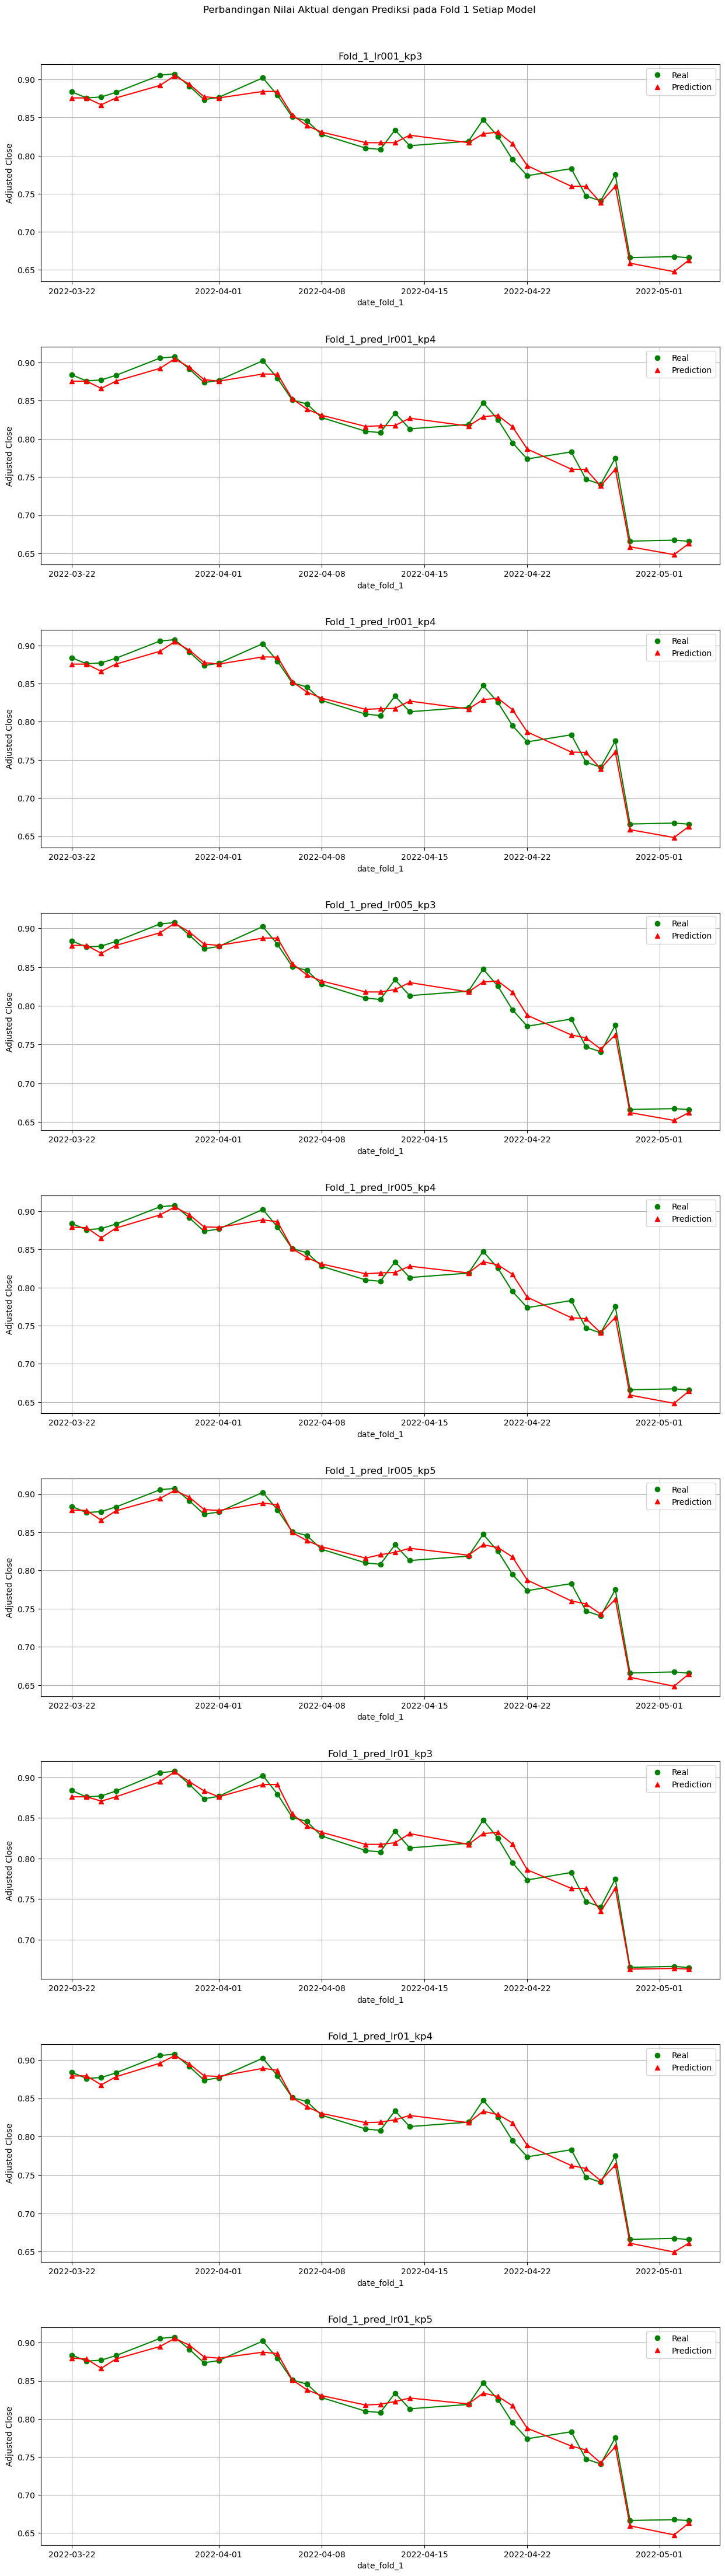

In [101]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_1_lr001_kp3', 'Fold_1_pred_lr001_kp4', 'Fold_1_pred_lr001_kp4',
        'Fold_1_pred_lr005_kp3', 'Fold_1_pred_lr005_kp4', 'Fold_1_pred_lr005_kp5',
        'Fold_1_pred_lr01_kp3', 'Fold_1_pred_lr01_kp4', 'Fold_1_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_1']
    pred_fold_1 = globals()[df]['pred_fold_1']
    date_fold_1 = globals()[df]['date_fold_1']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_1')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 1 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


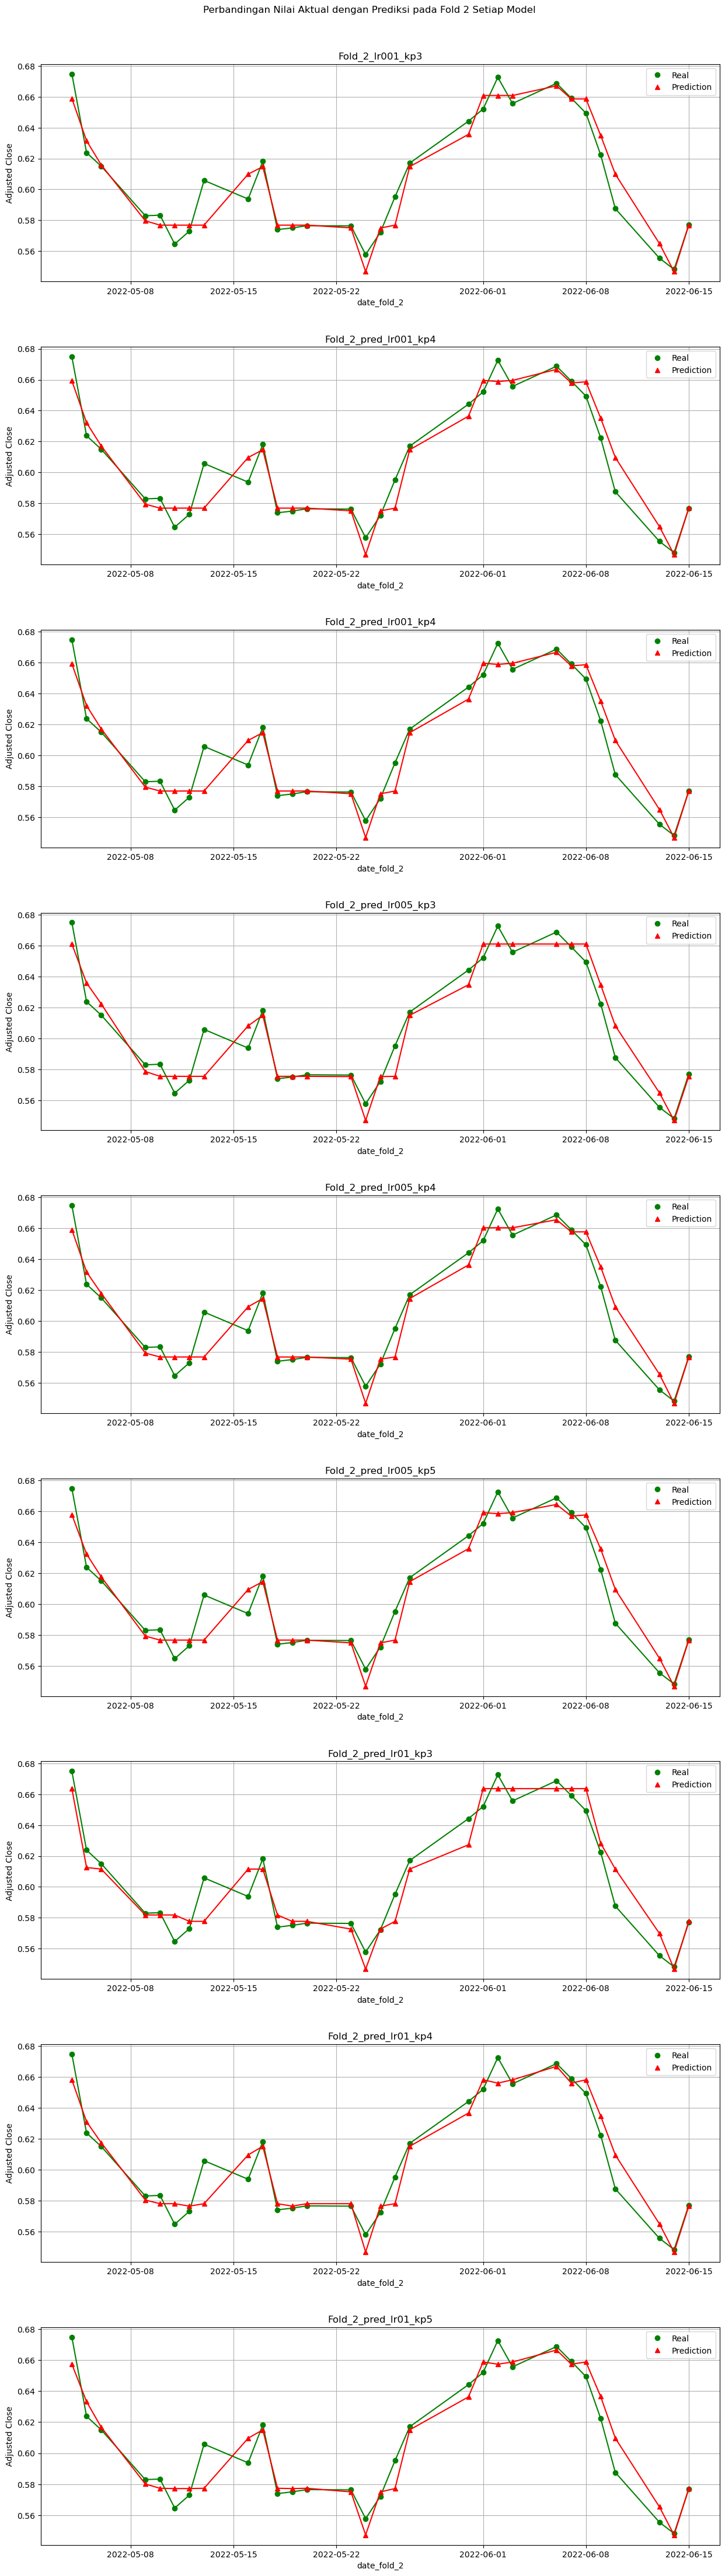

In [102]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_2_lr001_kp3', 'Fold_2_pred_lr001_kp4', 'Fold_2_pred_lr001_kp4',
        'Fold_2_pred_lr005_kp3', 'Fold_2_pred_lr005_kp4', 'Fold_2_pred_lr005_kp5',
        'Fold_2_pred_lr01_kp3', 'Fold_2_pred_lr01_kp4', 'Fold_2_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_2']
    pred_fold_1 = globals()[df]['pred_fold_2']
    date_fold_1 = globals()[df]['date_fold_2']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_2')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 2 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


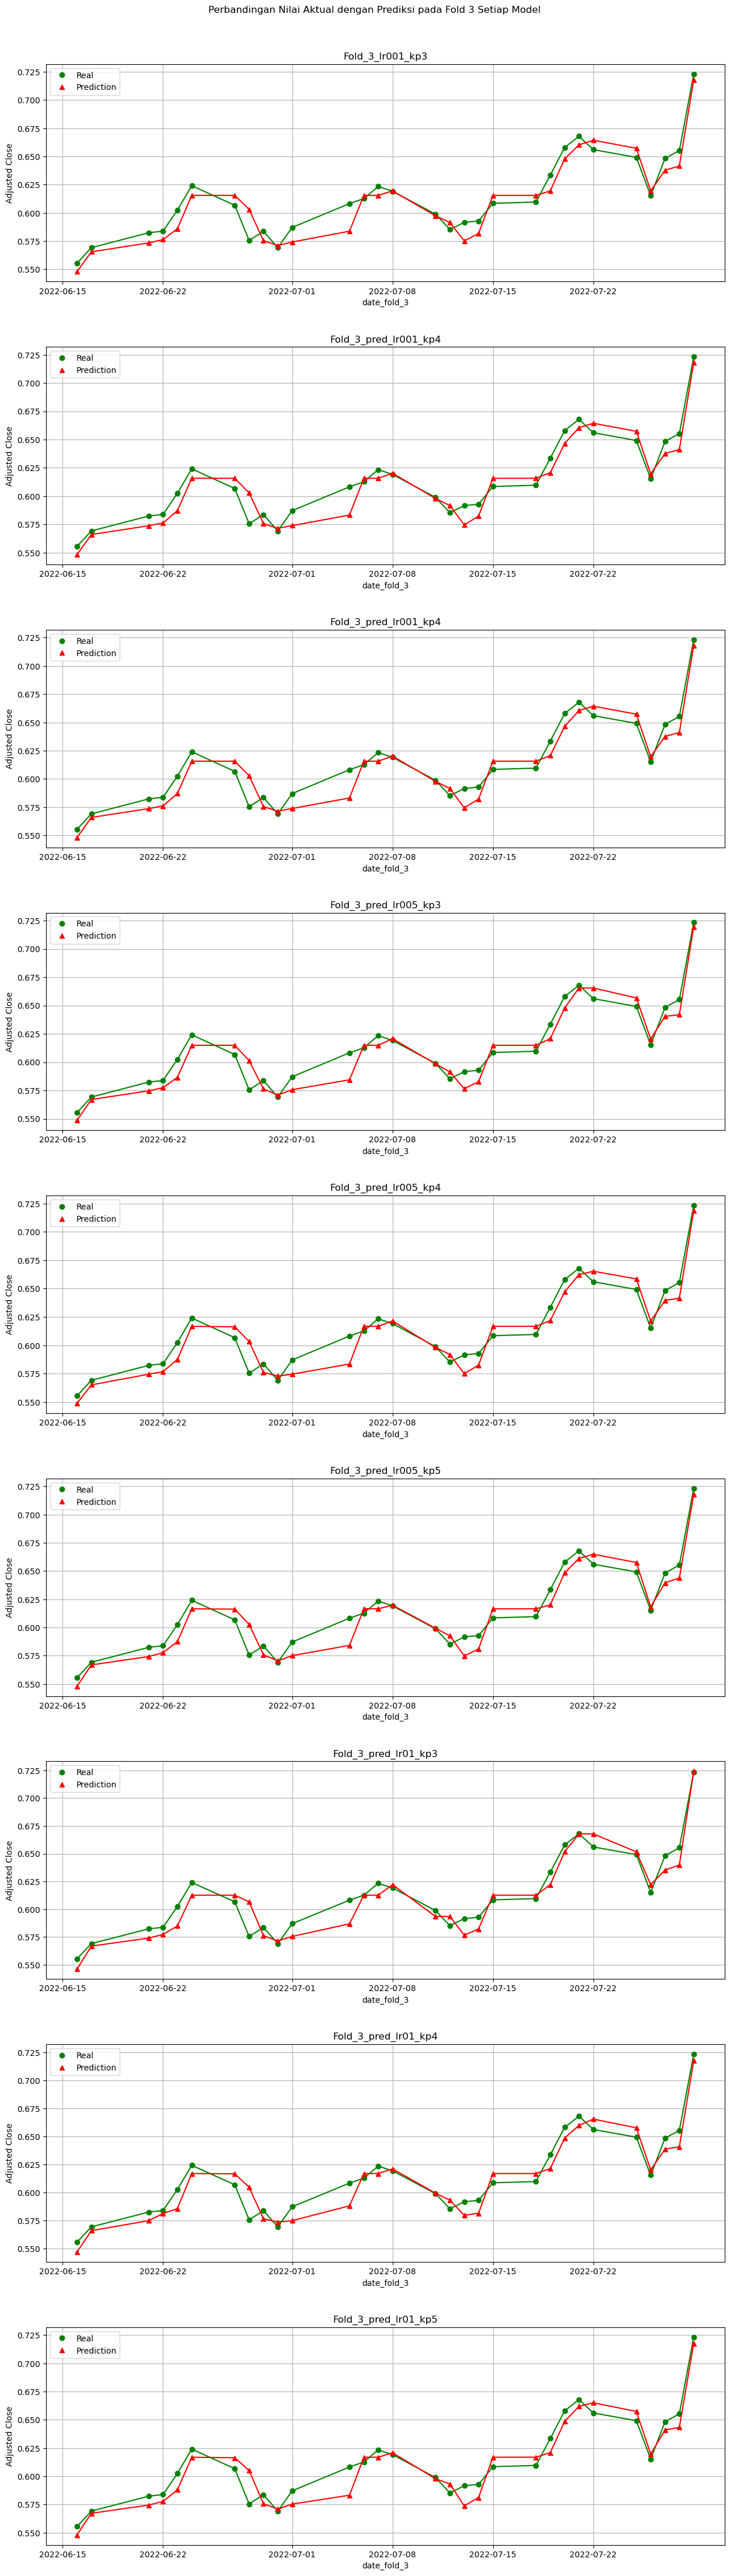

In [103]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_3_lr001_kp3', 'Fold_3_pred_lr001_kp4', 'Fold_3_pred_lr001_kp4',
        'Fold_3_pred_lr005_kp3', 'Fold_3_pred_lr005_kp4', 'Fold_3_pred_lr005_kp5',
        'Fold_3_pred_lr01_kp3', 'Fold_3_pred_lr01_kp4', 'Fold_3_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_3']
    pred_fold_1 = globals()[df]['pred_fold_3']
    date_fold_1 = globals()[df]['date_fold_3']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_3')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 3 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


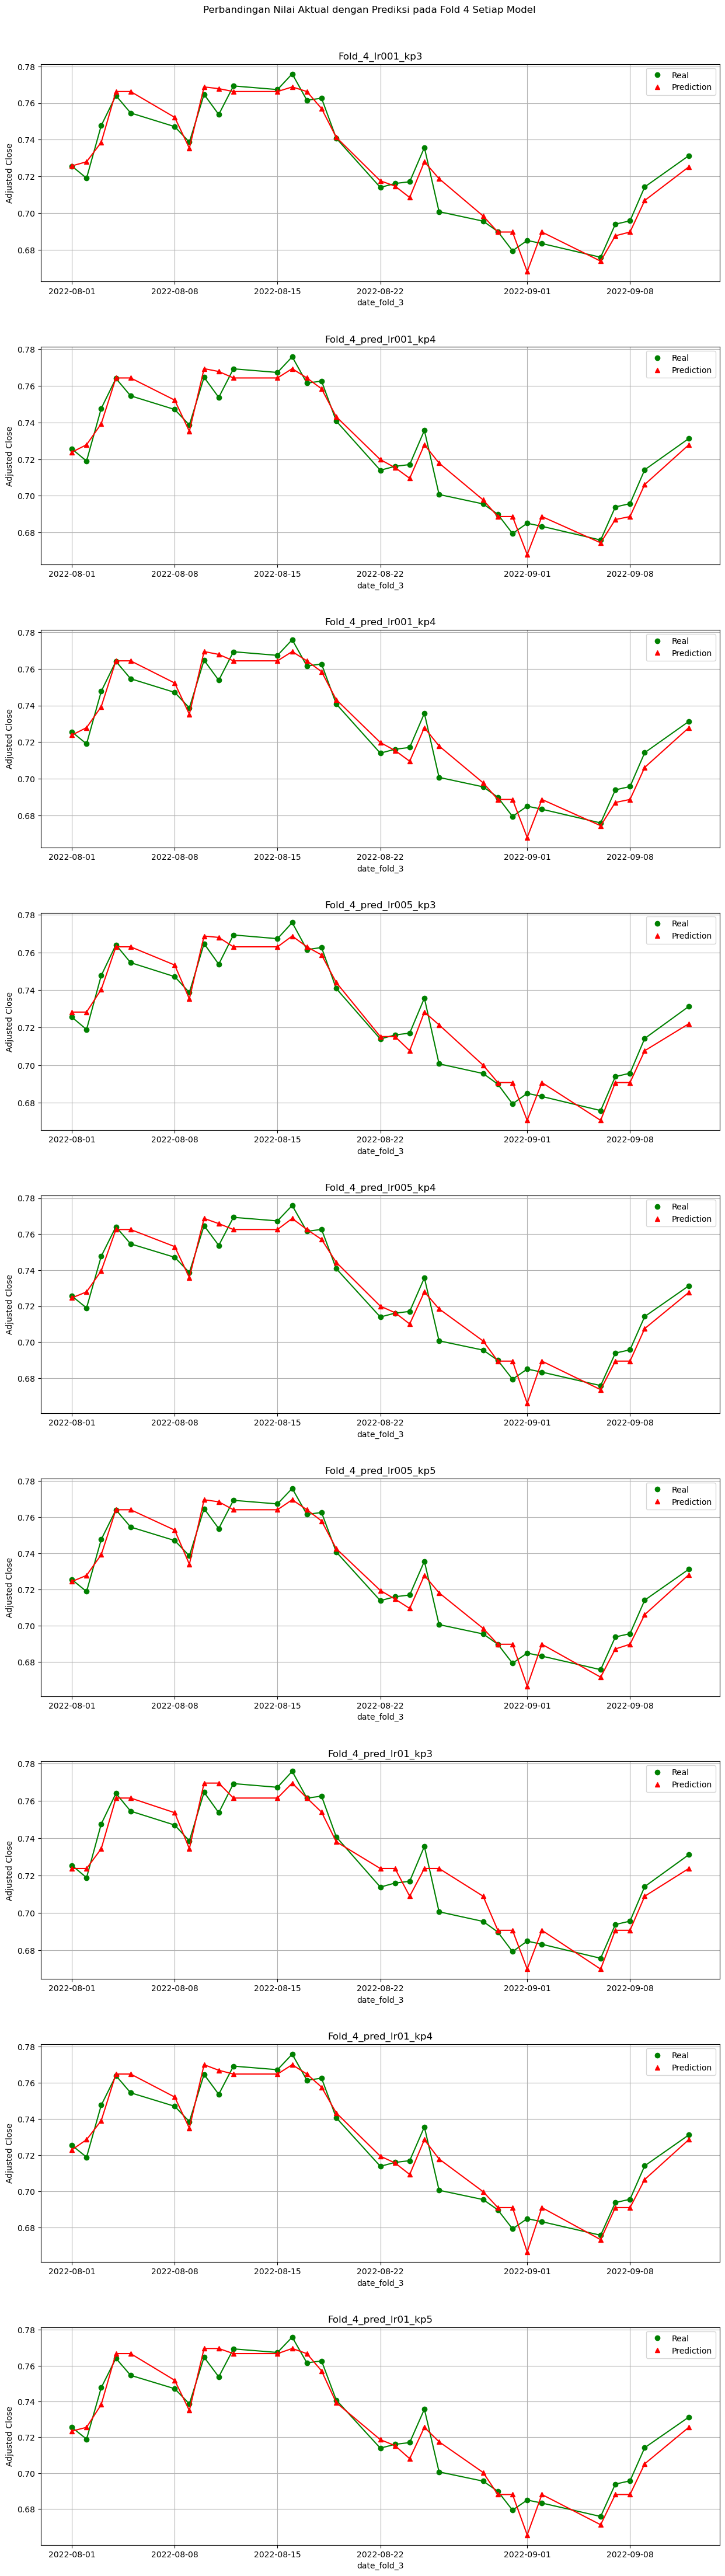

In [104]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_4_lr001_kp3', 'Fold_4_pred_lr001_kp4', 'Fold_4_pred_lr001_kp4',
        'Fold_4_pred_lr005_kp3', 'Fold_4_pred_lr005_kp4', 'Fold_4_pred_lr005_kp5',
        'Fold_4_pred_lr01_kp3', 'Fold_4_pred_lr01_kp4', 'Fold_4_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_4']
    pred_fold_1 = globals()[df]['pred_fold_4']
    date_fold_1 = globals()[df]['date_fold_4']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_3')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 4 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


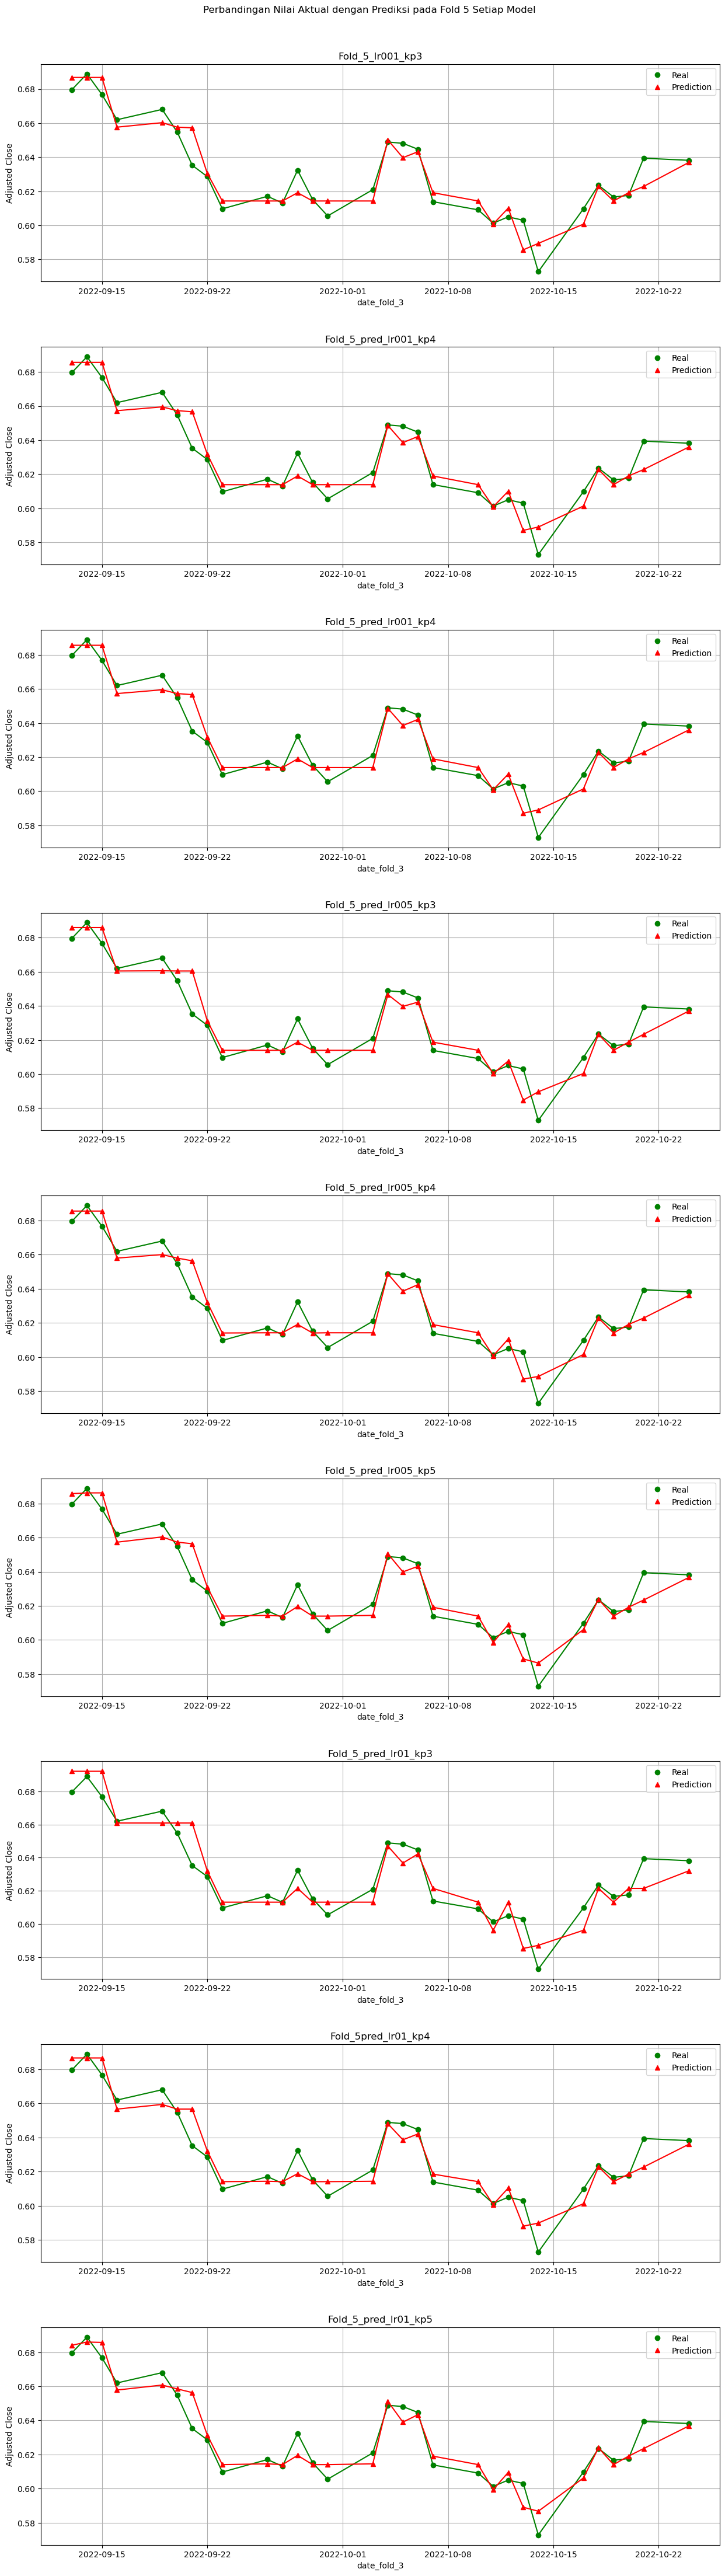

In [105]:
pred = ['pred_lr001_kp3', 'pred_lr001_kp4', 'pred_lr001_kp4',
        'pred_lr005_kp3', 'pred_lr005_kp4', 'pred_lr005_kp5',
        'pred_lr01_kp3', 'pred_lr01_kp4', 'pred_lr01_kp5']

titles = ['Fold_5_lr001_kp3', 'Fold_5_pred_lr001_kp4', 'Fold_5_pred_lr001_kp4',
        'Fold_5_pred_lr005_kp3', 'Fold_5_pred_lr005_kp4', 'Fold_5_pred_lr005_kp5',
        'Fold_5_pred_lr01_kp3', 'Fold_5pred_lr01_kp4', 'Fold_5_pred_lr01_kp5']

fig, axs  = plt.subplots(9, 1, figsize=(15, 50))

for i, df in enumerate(pred):
    real_fold_1 = globals()[df]['real_fold_5']
    pred_fold_1 = globals()[df]['pred_fold_5']
    date_fold_1 = globals()[df]['date_fold_5']
    
    axs[i].plot(date_fold_1, real_fold_1, 'o', color='green', label='Real')
    axs[i].plot(date_fold_1, real_fold_1, color='green', linestyle='-')
    axs[i].plot(date_fold_1, pred_fold_1, '^', color='red', label='Prediction')
    axs[i].plot(date_fold_1, pred_fold_1, color='red', linestyle='-')
    axs[i].set_xlabel('date_fold_3')
    axs[i].set_ylabel('Adjusted Close')
    axs[i].set_title(titles[i])
    axs[i].grid()
    axs[i].legend()

plt.suptitle('Perbandingan Nilai Aktual dengan Prediksi pada Fold 5 Setiap Model')
plt.subplots_adjust(top=0.96, hspace=0.3)
plt.show()


#### Visualisasi nilai Importance

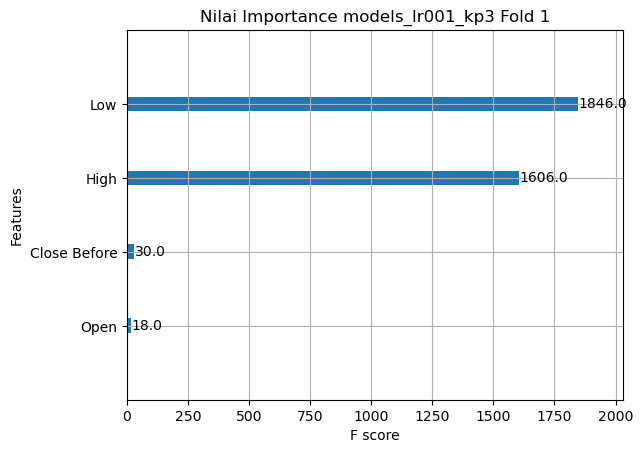

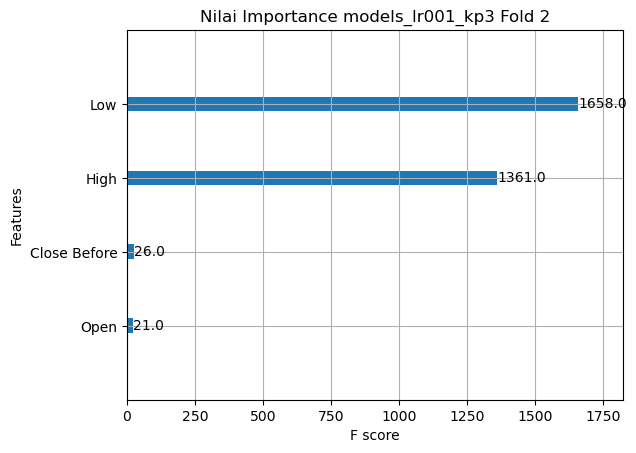

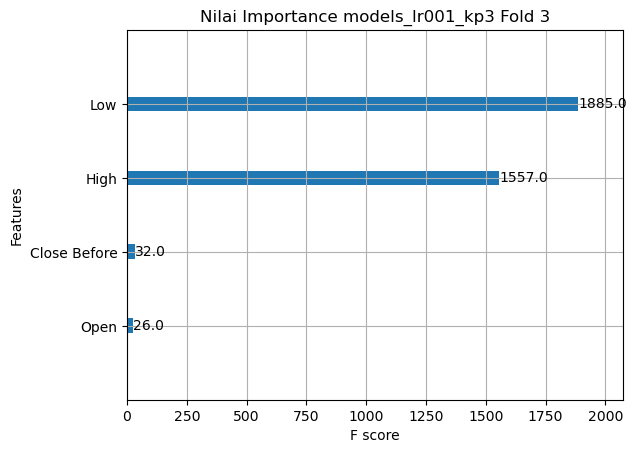

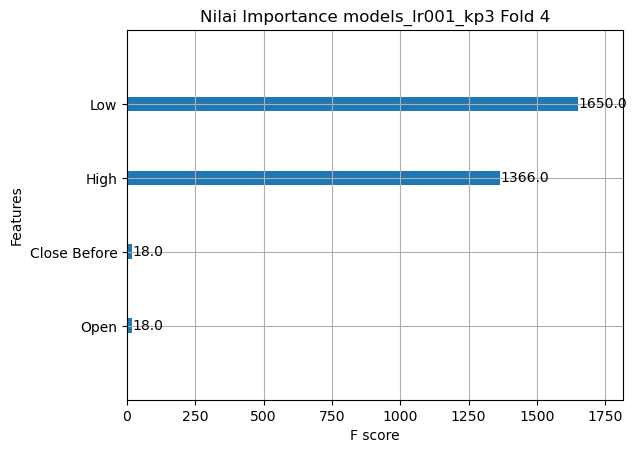

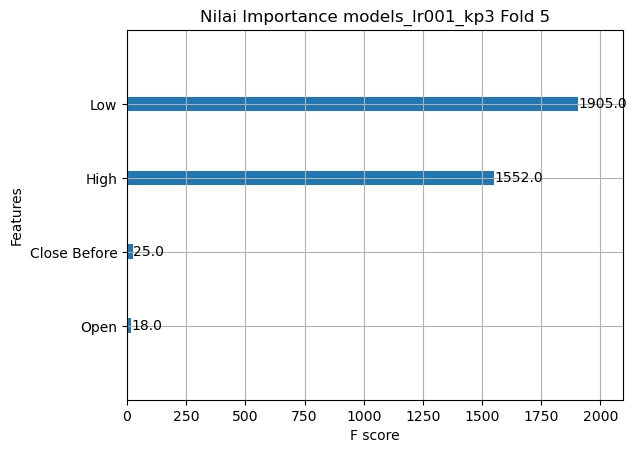

In [106]:
for i, model in enumerate(models_lr001_kp3):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr001_kp3 Fold {i+1}")

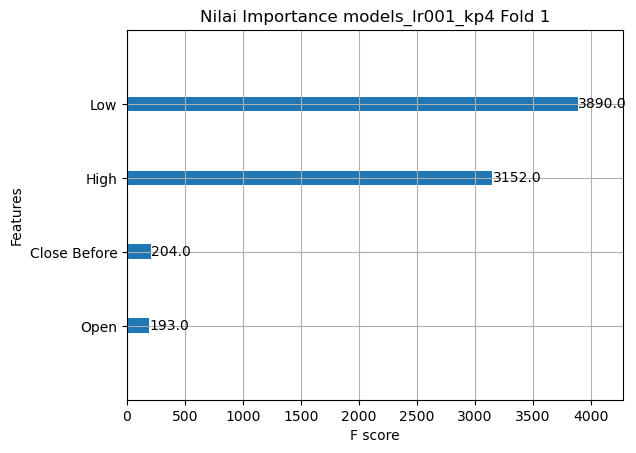

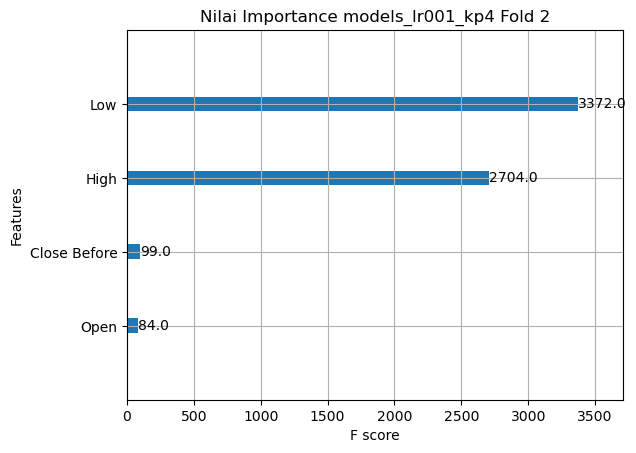

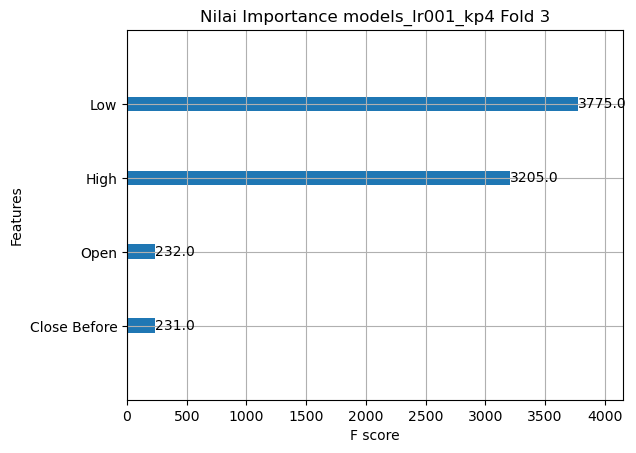

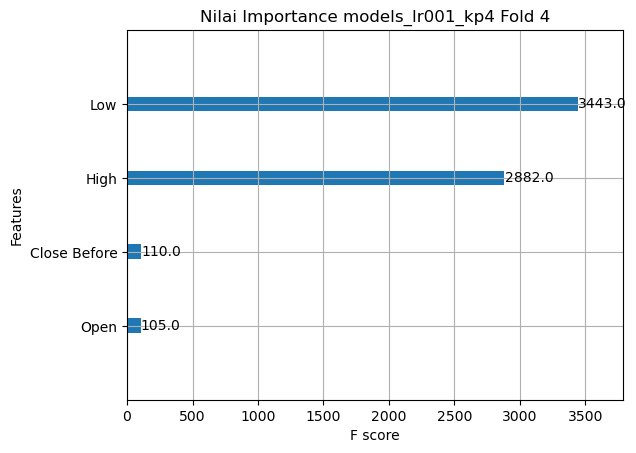

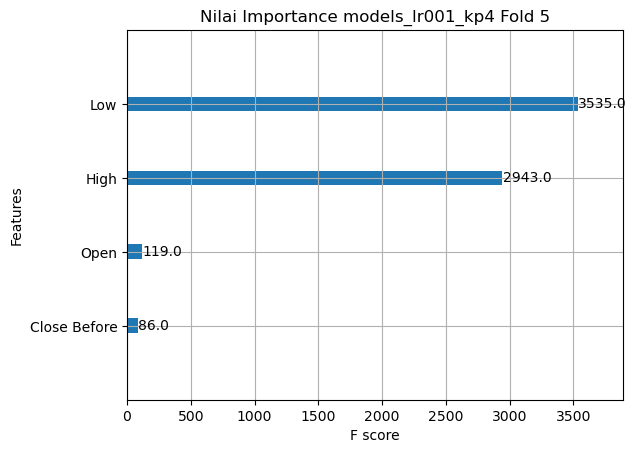

In [107]:
for i, model in enumerate(models_lr001_kp4):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr001_kp4 Fold {i+1}")

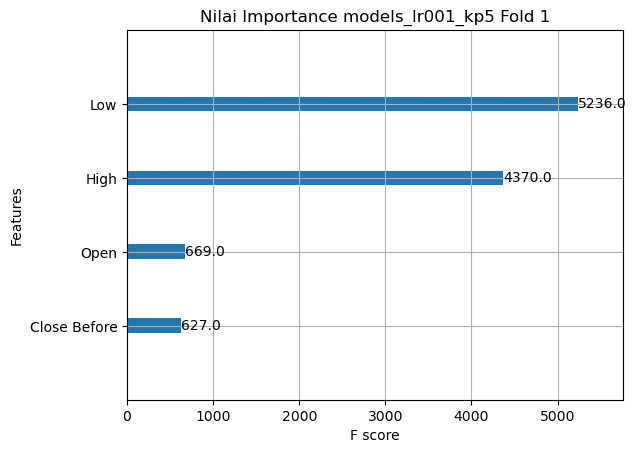

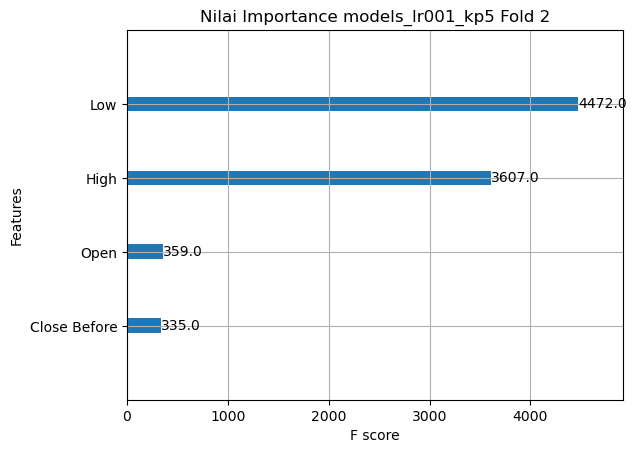

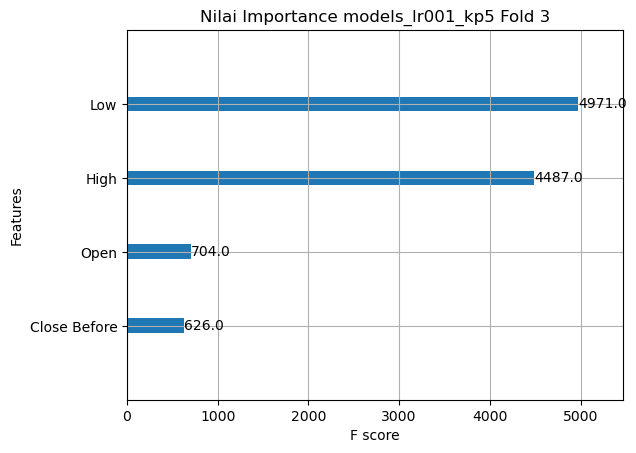

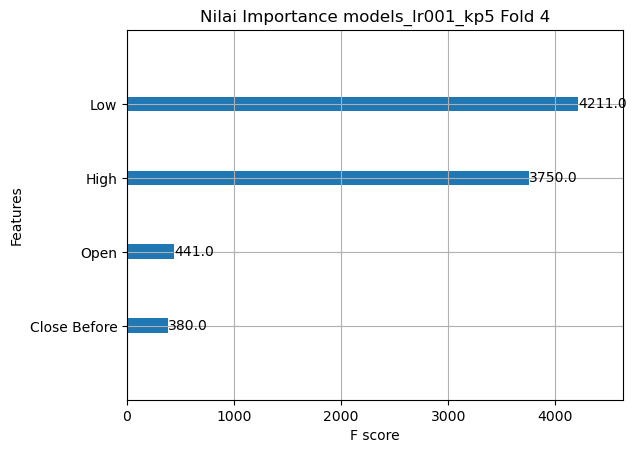

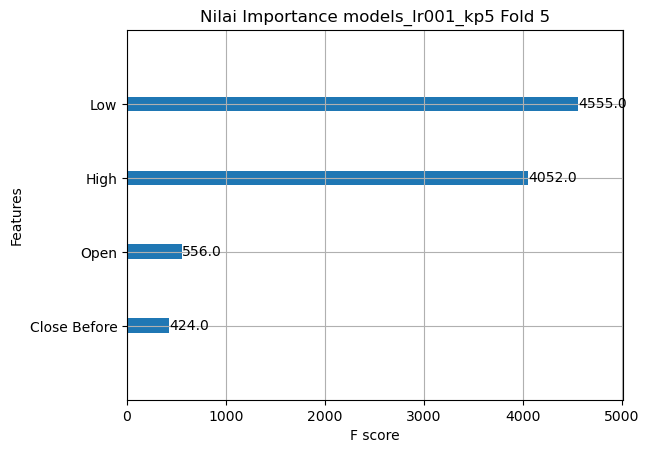

In [108]:
for i, model in enumerate(models_lr001_kp5):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr001_kp5 Fold {i+1}")

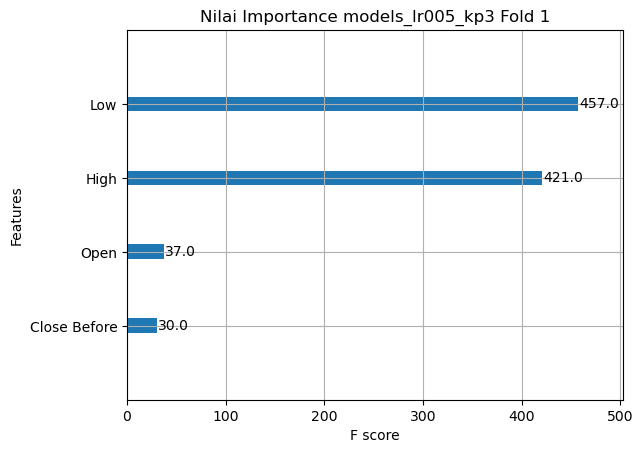

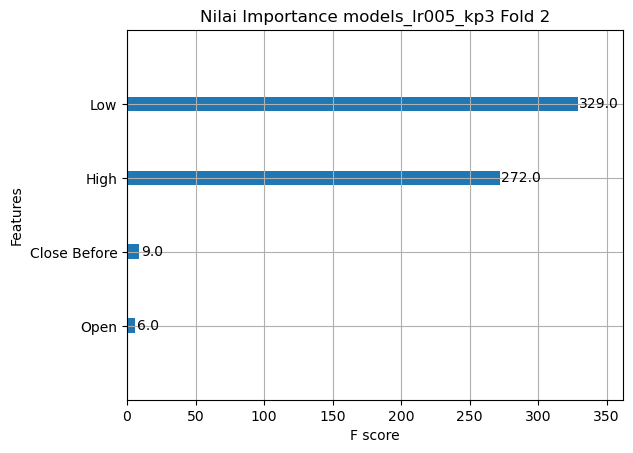

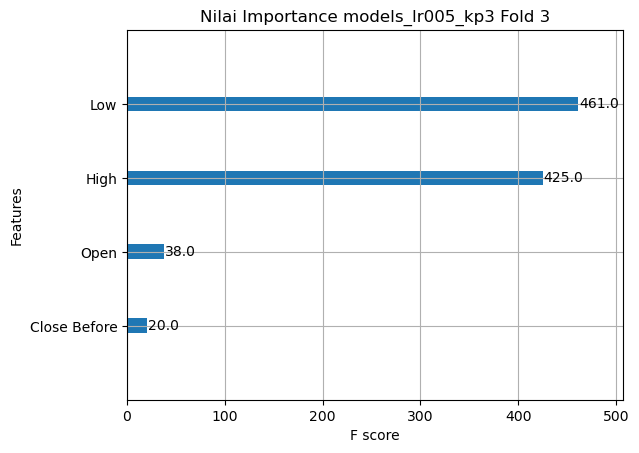

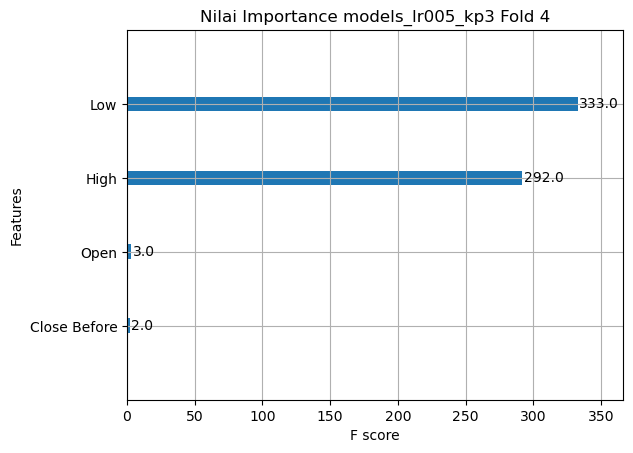

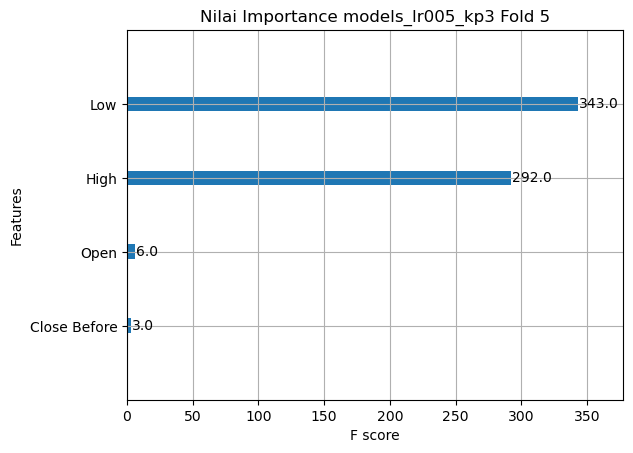

In [109]:
for i, model in enumerate(models_lr005_kp3):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr005_kp3 Fold {i+1}")

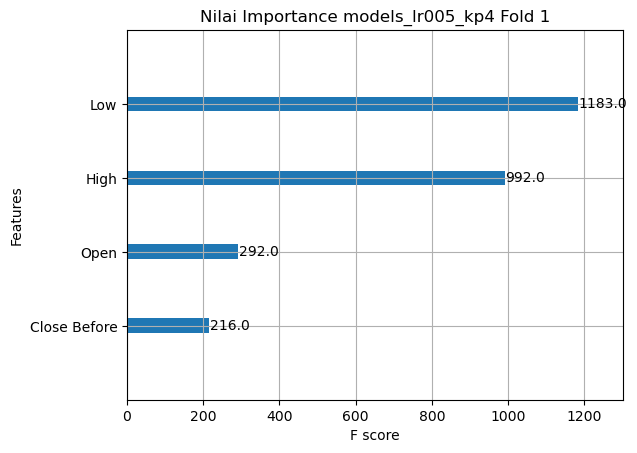

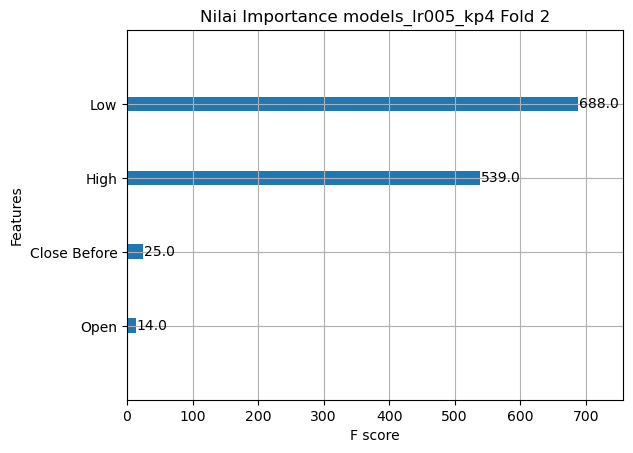

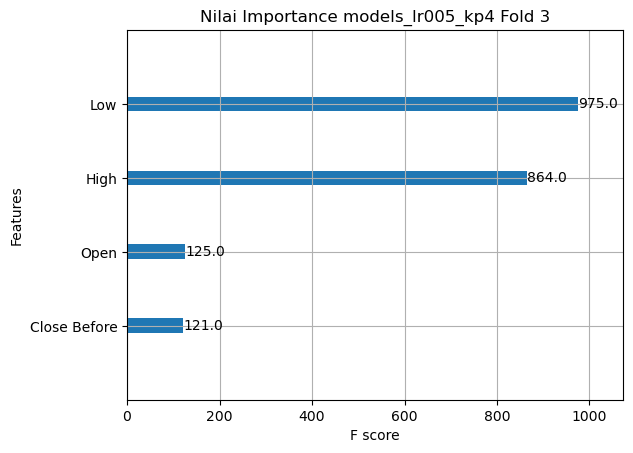

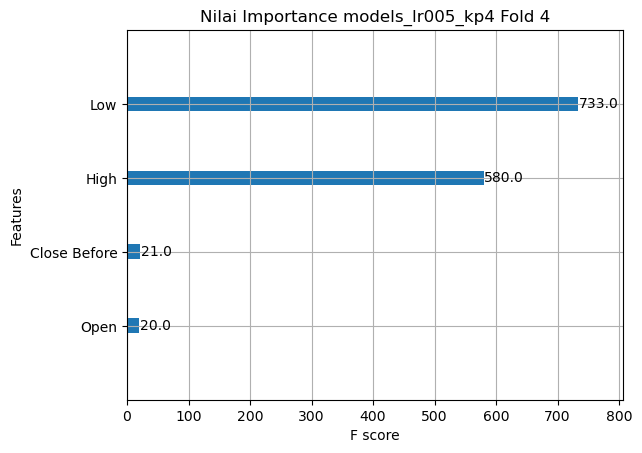

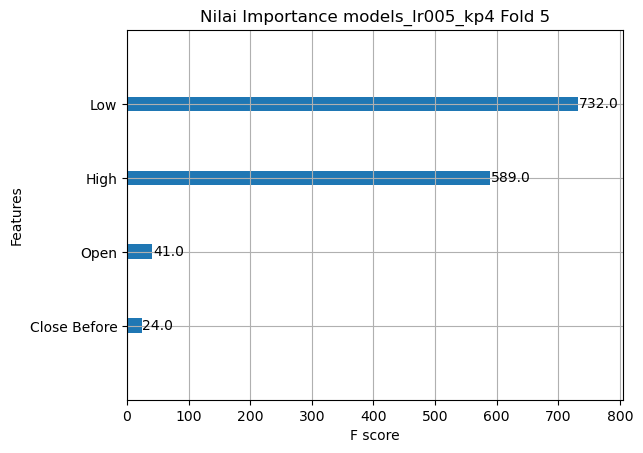

In [110]:
for i, model in enumerate(models_lr005_kp4):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr005_kp4 Fold {i+1}")

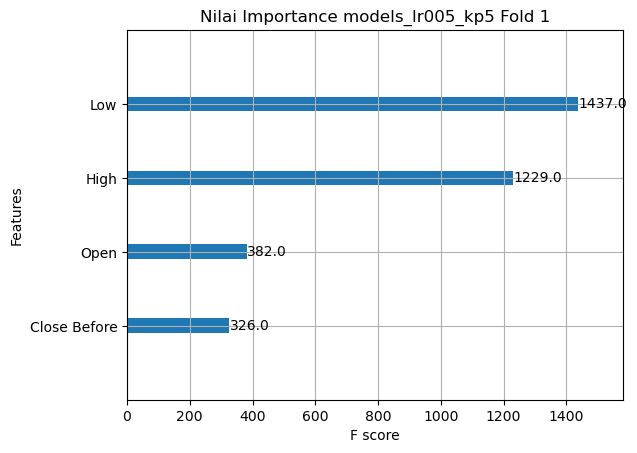

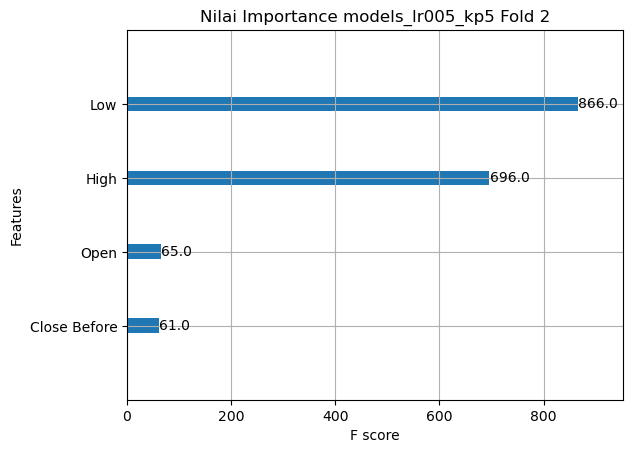

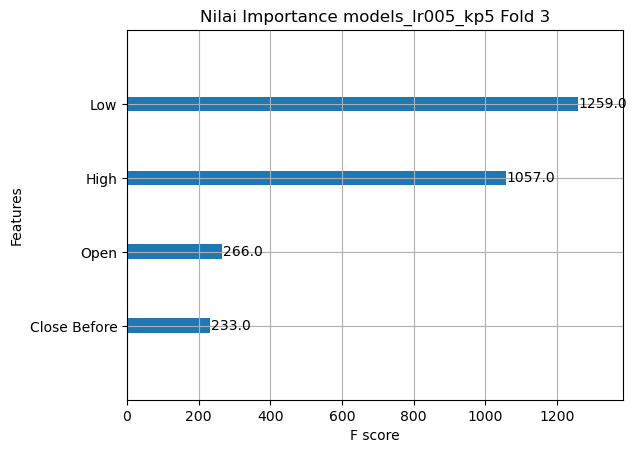

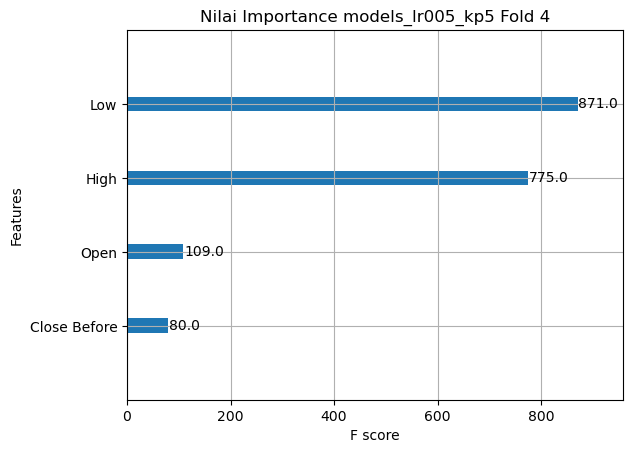

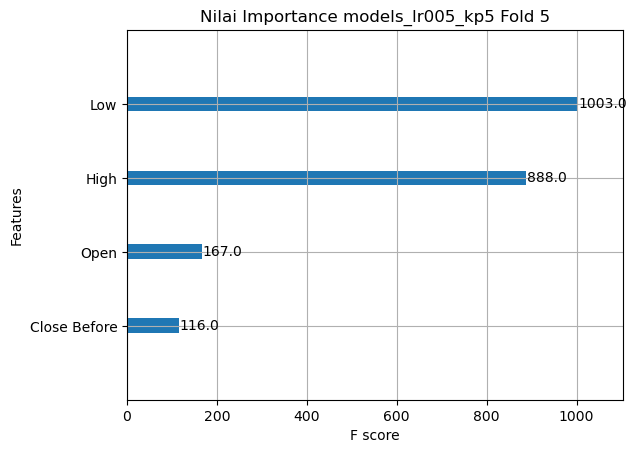

In [113]:
for i, model in enumerate(models_lr005_kp5):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr005_kp5 Fold {i+1}")

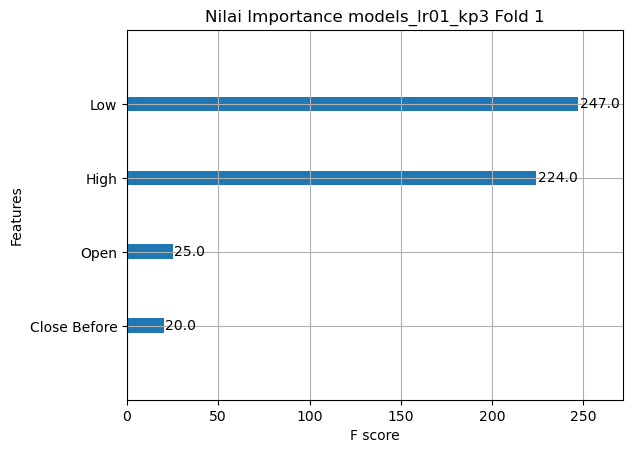

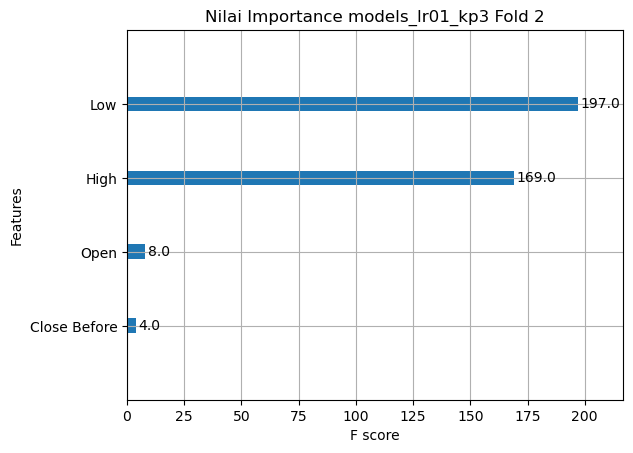

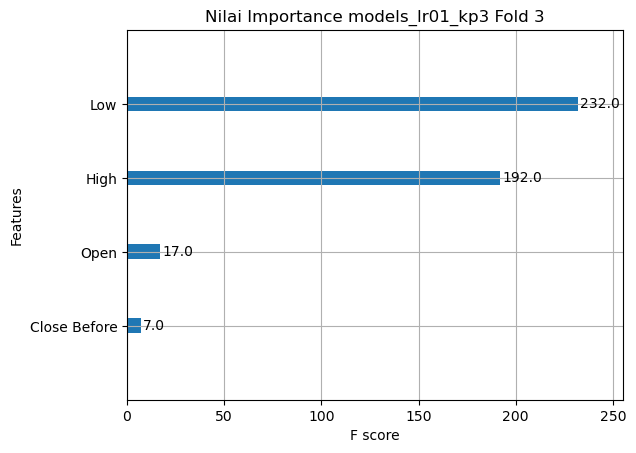

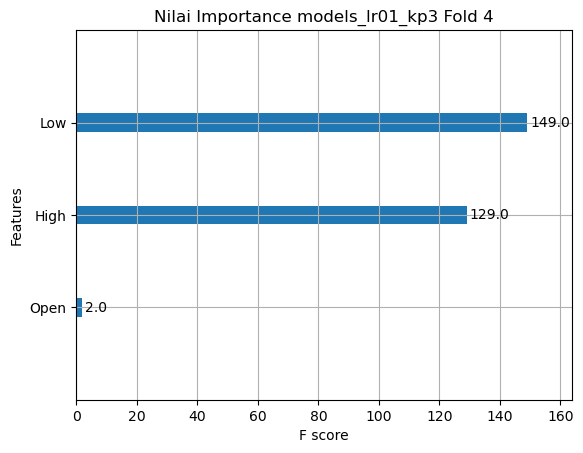

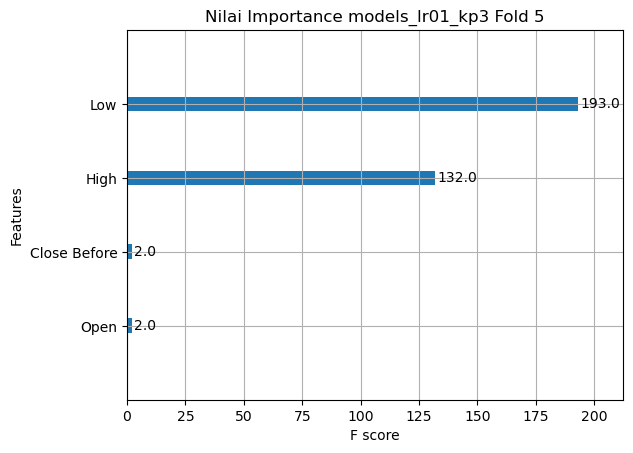

In [114]:
for i, model in enumerate(models_lr01_kp3):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr01_kp3 Fold {i+1}")

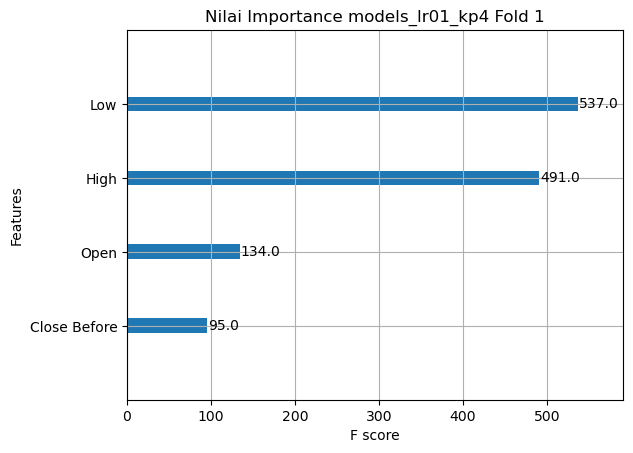

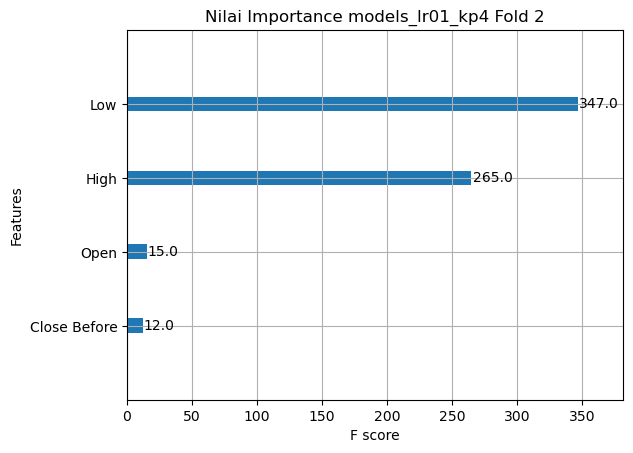

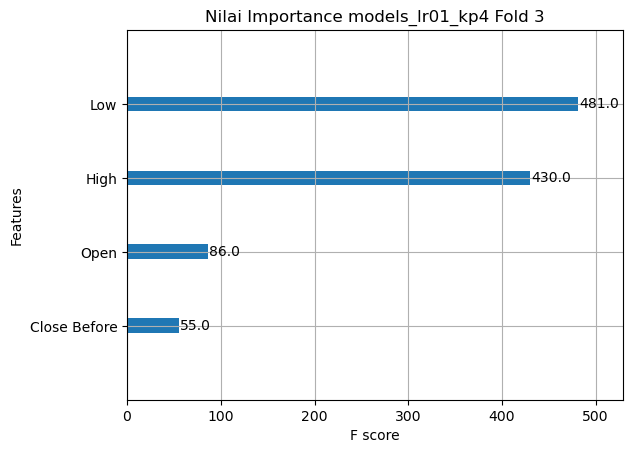

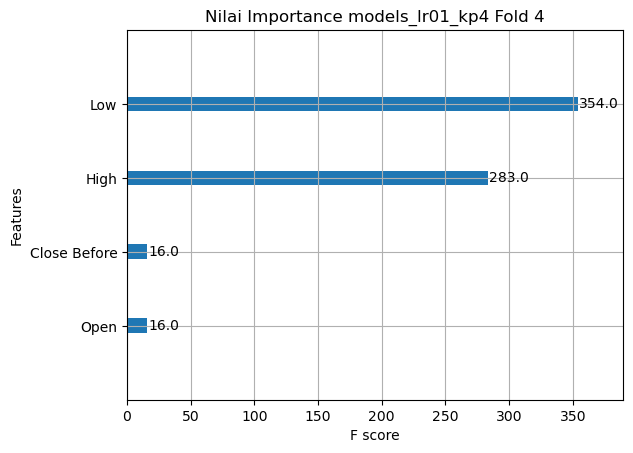

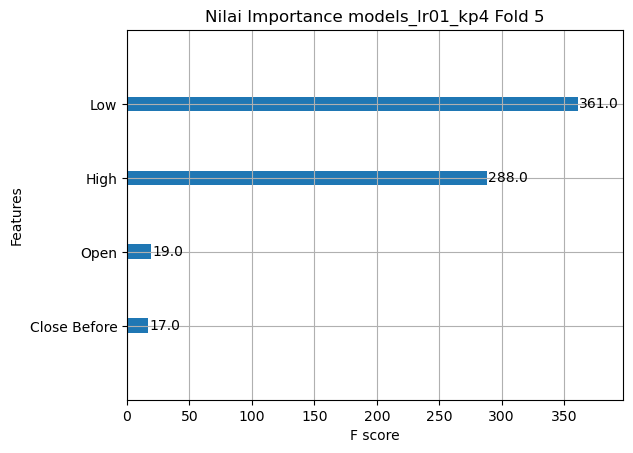

In [115]:
for i, model in enumerate(models_lr01_kp4):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr01_kp4 Fold {i+1}")

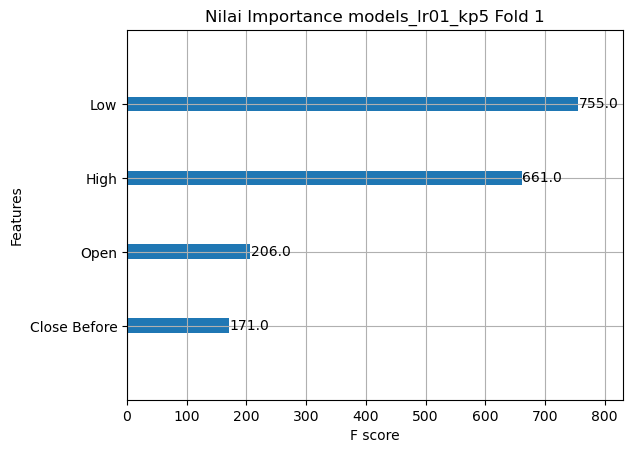

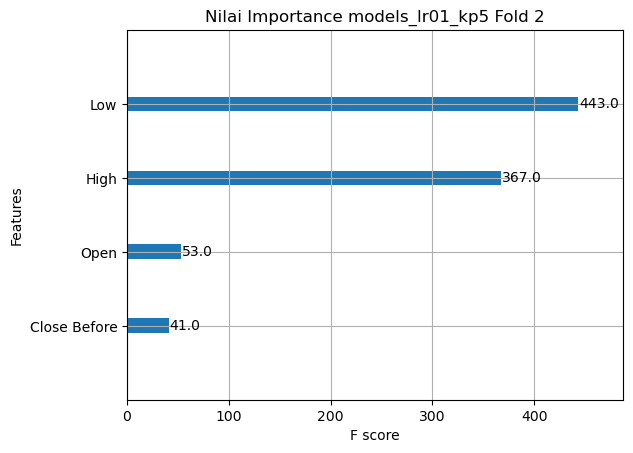

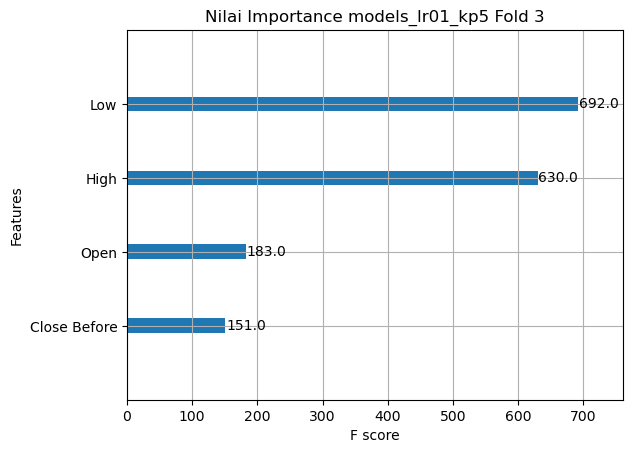

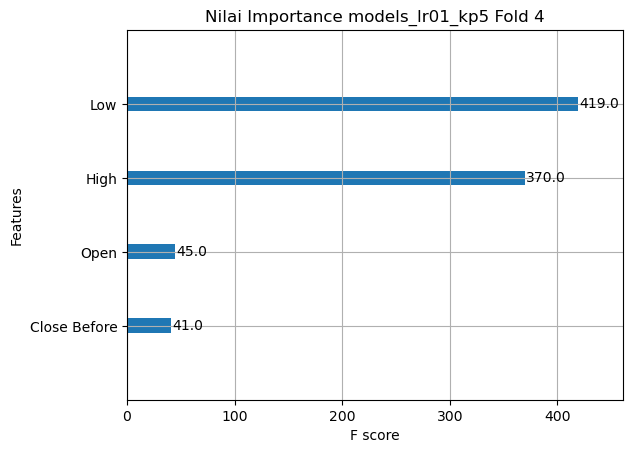

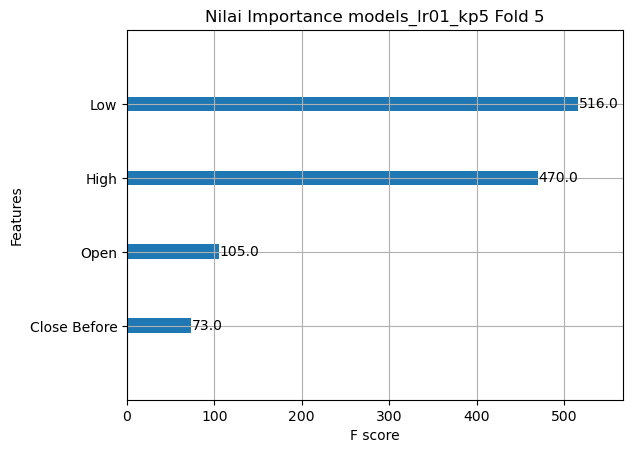

In [116]:
for i, model in enumerate(models_lr01_kp5):
    xgb.plot_importance(model, title=f"Nilai Importance models_lr01_kp5 Fold {i+1}")